In [2]:
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nibabel.processing as nibpro
import SimpleITK as sitk
import json
import matplotlib.patches as mpatches
from pathlib import Path
from PIL import Image, ImageEnhance
from matplotlib import cm
import matplotlib
import re
import shutil
import sys
if not str(Path("../..").resolve()) in sys.path:
    sys.path.append(str(Path("../..").resolve()))
from slice_inflate.datasets.align_mmwhs import nifti_transform, cut_slice, crop_around_label_center
from slice_inflate.models.affine_transform import compute_rotation_matrix_from_ortho6d, get_random_affine
from collections import defaultdict
from slice_inflate.utils.common_utils import DotDict
from slice_inflate.models.affine_transform import AffineTransformModule
from tqdm import trange

c3d = "/shared/c3d-1.1.0-Linux-x86_64/bin/c3d"

MMWHS_BASE_PATH = "../../data/MMWHS_notest"




Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [3]:
def plot_slices(red_slice, green_slice, yellow_slice, vmin=0.0, vmax=1.0):
    fig_img = plt.figure()
    new_plot = fig_img.add_subplot(131)
    plt.imshow(red_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)
    new_plot = fig_img.add_subplot(132)
    plt.imshow(green_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)
    new_plot = fig_img.add_subplot(133)
    plt.imshow(yellow_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)

    axs = fig_img.axes
    axs[0].set_title("red")
    axs[1].set_title("green")
    axs[2].set_title("yellow")
    plt.show()

# Split dataset

In [ ]:
test_cases = [1001,1002,1003,1005,1006]
train_cases = set(range(1001,1021)) - set(test_cases)
train_cases = list(train_cases)

ct_paths = list(Path(MMWHS_BASE_PATH, 'untouched/ct_train').glob('*.nii.gz'))
mr_paths = list(Path(MMWHS_BASE_PATH, 'untouched/mr_train').glob('*.nii.gz'))

paths = ct_paths + mr_paths

train_paths = sorted(filter(lambda _path: any([str(c) in str(_path) for c in train_cases]), paths))
test_paths = sorted(filter(lambda _path: any([str(c) in str(_path) for c in test_cases]), paths))

for p in train_paths:
    dest_path = Path(str(p).replace('train', 'train_selection').replace('untouched/', ''))
    dest_path.parent.mkdir(exist_ok=True)
    print(f"{p} -> {dest_path}")
    shutil.copy(p, dest_path)
for p in test_paths:
    dest_path = Path(str(p).replace('train', 'test_selection').replace('untouched/', ''))
    dest_path.parent.mkdir(exist_ok=True)
    print(f"{p} -> {dest_path}")
    shutil.copy(p, dest_path)

../../data/MMWHS2/untouched/ct_train/ct_train_1004_image.nii.gz -> ../../data/MMWHS2/ct_train_selection/ct_train_selection_1004_image.nii.gz
../../data/MMWHS2/untouched/ct_train/ct_train_1004_label.nii.gz -> ../../data/MMWHS2/ct_train_selection/ct_train_selection_1004_label.nii.gz
../../data/MMWHS2/untouched/ct_train/ct_train_1007_image.nii.gz -> ../../data/MMWHS2/ct_train_selection/ct_train_selection_1007_image.nii.gz
../../data/MMWHS2/untouched/ct_train/ct_train_1007_label.nii.gz -> ../../data/MMWHS2/ct_train_selection/ct_train_selection_1007_label.nii.gz
../../data/MMWHS2/untouched/ct_train/ct_train_1008_image.nii.gz -> ../../data/MMWHS2/ct_train_selection/ct_train_selection_1008_image.nii.gz
../../data/MMWHS2/untouched/ct_train/ct_train_1008_label.nii.gz -> ../../data/MMWHS2/ct_train_selection/ct_train_selection_1008_label.nii.gz
../../data/MMWHS2/untouched/ct_train/ct_train_1009_image.nii.gz -> ../../data/MMWHS2/ct_train_selection/ct_train_selection_1009_image.nii.gz
../../data/MM

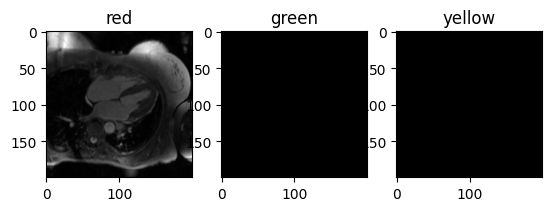

In [ ]:
FOV_MM = torch.tensor([300,300,300])
FOV_VOX = torch.tensor([200,200,200])

mri_1002_nii = nib.load(Path(MMWHS_BASE_PATH, "mr_test_selection/mr_test_selection_1002_image.nii.gz"))
mri_1002_gt_nii = nib.load(Path(MMWHS_BASE_PATH, "mr_test_selection/mr_test_selection_1002_label.nii.gz"))

_4CH_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_4CH.mat"))
_SA_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA.mat"))

_4CH_image, _, _4CH_affine = nifti_transform(
    torch.as_tensor(mri_1002_nii.get_fdata()).unsqueeze(0).unsqueeze(0), 
    torch.as_tensor(mri_1002_nii.affine).unsqueeze(0), 
    _4CH_to_ras_mat.unsqueeze(0), 
    fov_mm=FOV_MM, 
    fov_vox=FOV_VOX)

_4CH_label, *_ = nifti_transform(
    torch.as_tensor(mri_1002_gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0), 
    torch.as_tensor(mri_1002_gt_nii.affine).unsqueeze(0), 
    _4CH_to_ras_mat.unsqueeze(0), fov_mm=FOV_MM, 
    fov_vox=FOV_VOX, is_label=True)

ref_img_path = Path(MMWHS_BASE_PATH, "preprocessed/train_HLA_4_chamber/mr_train_1002_image_HLA.nii.gz")
ref_label_path = Path(MMWHS_BASE_PATH, "preprocessed/train_HLA_4_chamber/mr_train_1002_label_HLA.nii.gz")
ref_img_path.parent.mkdir(exist_ok=True, parents=True)

_4CH_slice = cut_slice(_4CH_image)

_4CH_image = _4CH_image.squeeze()
_4CH_label = _4CH_label.squeeze()
_4CH_slice = _4CH_slice.squeeze()

nib.save(nib.Nifti1Image(_4CH_image.numpy(), affine=_4CH_affine.squeeze()), ref_img_path)
nib.save(nib.Nifti1Image(_4CH_label.int().numpy(), affine=_4CH_affine.squeeze()), ref_label_path)

plot_slices(_4CH_slice, torch.zeros_like(_4CH_slice), torch.zeros_like(_4CH_slice), vmax=_4CH_image.max().item())

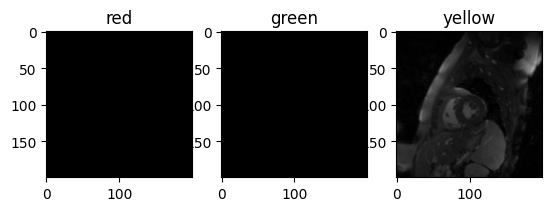

In [9]:
SA_image, _, SA_affine = nifti_transform(
    torch.as_tensor(mri_1002_nii.get_fdata()).unsqueeze(0).unsqueeze(0), 
    torch.as_tensor(mri_1002_nii.affine).unsqueeze(0), 
    _SA_to_ras_mat.unsqueeze(0), 
    fov_mm=FOV_MM, 
    fov_vox=FOV_VOX)

yellow_label, *_ = nifti_transform(
    torch.as_tensor(mri_1002_gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0), 
    torch.as_tensor(mri_1002_gt_nii.affine).unsqueeze(0), 
    _SA_to_ras_mat.unsqueeze(0), fov_mm=FOV_MM, 
    fov_vox=FOV_VOX, is_label=True)

ref_img_path = Path(MMWHS_BASE_PATH, "preprocessed/train_SA/mr_train_1002_image_SA.nii.gz")
ref_label_path = Path(MMWHS_BASE_PATH, "preprocessed/train_SA/mr_train_1002_label_SA.nii.gz")
ref_img_path.parent.mkdir(exist_ok=True, parents=True)

yellow_slice = cut_slice(SA_image)

SA_image = SA_image.squeeze()
yellow_label = yellow_label.squeeze()
yellow_slice = yellow_slice.squeeze()

nib.save(nib.Nifti1Image(SA_image.numpy(), affine=SA_affine.squeeze()), ref_img_path)
nib.save(nib.Nifti1Image(yellow_label.int().numpy(), affine=SA_affine.squeeze()), ref_label_path)

plot_slices(torch.zeros_like(yellow_slice), torch.zeros_like(yellow_slice), yellow_slice, vmax=SA_image.max().item())

### Prepare MMWHS: Register volumes based on 1002 fixed labels with c3d and store the affine

In [2]:
FIXED_ID = 1002
moving_ids = list(range(1001, 1021, 1))

orig_fixed_label_filepath = Path(MMWHS_BASE_PATH, "mr_test_selection", f"mr_test_selection_{FIXED_ID}_label.nii.gz")
orig_fixed_image_filepath = Path(MMWHS_BASE_PATH, "mr_test_selection", f"mr_test_selection_{FIXED_ID}_image.nii.gz")

nii_orig_label = nib.load(orig_fixed_label_filepath)
nii_orig_image = nib.load(orig_fixed_image_filepath)

CROP_SIZE = torch.tensor([256,256,128])

orig_label = torch.as_tensor(nii_orig_label.get_fdata()).unsqueeze(0).unsqueeze(0)
orig_label[orig_label == 820] = 0 # Remove pulmonary artery and aorta
orig_label[orig_label == 850] = 0

orig_image = torch.as_tensor(nii_orig_image.get_fdata()).unsqueeze(0).unsqueeze(0)

cropped_fixed_label, cropped_fixed_volume, cropped_affine = \
    crop_around_label_center(orig_label, vox_size=CROP_SIZE, 
        image=orig_image, affine=torch.as_tensor(nii_orig_label.affine))

fixed_image_filepath = Path(MMWHS_BASE_PATH, "fixed_targets", "mr_train_1002_image_cropped.nii.gz")
fixed_label_filepath = Path(MMWHS_BASE_PATH, "fixed_targets", "mr_train_1002_label_cropped.nii.gz")

fixed_image_filepath.parent.mkdir(parents=True, exist_ok=True)
fixed_label_filepath.parent.mkdir(parents=True, exist_ok=True)

nib.save(nib.Nifti1Image(cropped_fixed_volume.squeeze().int().numpy(), affine=cropped_affine), fixed_image_filepath)
nib.save(nib.Nifti1Image(cropped_fixed_label.squeeze().int().numpy(), affine=cropped_affine), fixed_label_filepath)

DOF = 6
# USE_NNUNET_NAMES = False

for mod in ["CT", "MR"]:
    for m_id in moving_ids:

        affine_path = Path(MMWHS_BASE_PATH, "preprocessed", f"f{FIXED_ID}mr_m{m_id}{mod.lower()}.mat")
        affine_path.parent.mkdir(exist_ok=True, parents=True)

        moving_image_filepath = Path(MMWHS_BASE_PATH, f"{mod.lower()}_train_selection", f"{mod.lower()}_train_selection_{m_id}_image.nii.gz")
        moving_label_filepath = Path(MMWHS_BASE_PATH, f"{mod.lower()}_train_selection", f"{mod.lower()}_train_selection_{m_id}_label.nii.gz")

        if not (moving_image_filepath.is_file() and moving_label_filepath.is_file()): 
            moving_image_filepath = Path(MMWHS_BASE_PATH, f"{mod.lower()}_test_selection", f"{mod.lower()}_test_selection_{m_id}_image.nii.gz")
            moving_label_filepath = Path(MMWHS_BASE_PATH, f"{mod.lower()}_test_selection", f"{mod.lower()}_test_selection_{m_id}_label.nii.gz")

        print(f"Registering {m_id} to {FIXED_ID}")
        print(affine_path)
        
        !{c3d} {fixed_label_filepath} {moving_label_filepath} -align-landmarks {DOF} {affine_path}

Registering 1001 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1001ct.mat
Registering 1002 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1002ct.mat
Registering 1003 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1003ct.mat
Registering 1004 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1004ct.mat
Registering 1005 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1005ct.mat
Registering 1006 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1006ct.mat
Registering 1007 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1007ct.mat
Registering 1008 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1008ct.mat
Registering 1009 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1009ct.mat
Registering 1010 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1010ct.mat
Registering 1011 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1011ct.mat
Registering 1012 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1012ct.mat
Registering 1013 to 1002
../../data/MMWHS2/preprocessed/f1002mr_m1013ct.mat
Registering 

# Transform the volumes based on affines

In [2]:
FIXED_ID = 1002
moving_ids = list(range(1001, 1021, 1))
FOV_VOX = [160,160,160]

fixed_image_filepath = Path(MMWHS_BASE_PATH, "fixed_targets", "mr_train_1002_image_cropped.nii.gz")
fixed_label_filepath = Path(MMWHS_BASE_PATH, "fixed_targets", "mr_train_1002_label_cropped.nii.gz")

DOF = 6

def get_reg_filepath(_path: Path):
    prts = list(_path.parts)
    if prts[-2].startswith('mr_'):
        prts[-2] = prts[-2].replace('mr_', 'mr_registered_')
    elif prts[-2].startswith('ct_'):
        prts[-2] = prts[-2].replace('ct_', 'ct_registered_')

    prts[-1] = prts[-1].replace('.nii.gz', '_registered.nii.gz')
    return Path(*prts)

for mod in ["CT", "MR"]:
    for m_id in moving_ids:

        affine_path = Path(MMWHS_BASE_PATH, "preprocessed", f"f{FIXED_ID}mr_m{m_id}{mod.lower()}.mat")

        moving_image_filepath = Path(MMWHS_BASE_PATH, f"{mod.lower()}_train_selection", f"{mod.lower()}_train_selection_{m_id}_image.nii.gz")
        moving_label_filepath = Path(MMWHS_BASE_PATH, f"{mod.lower()}_train_selection", f"{mod.lower()}_train_selection_{m_id}_label.nii.gz")

        if not (moving_image_filepath.is_file() and moving_label_filepath.is_file()): 
            moving_image_filepath = Path(MMWHS_BASE_PATH, f"{mod.lower()}_test_selection", f"{mod.lower()}_test_selection_{m_id}_image.nii.gz")
            moving_label_filepath = Path(MMWHS_BASE_PATH, f"{mod.lower()}_test_selection", f"{mod.lower()}_test_selection_{m_id}_label.nii.gz")

        print(f"Transforming {m_id} to {FIXED_ID}")

        image_output_filepath = get_reg_filepath(moving_image_filepath)
        label_output_filepath = get_reg_filepath(moving_label_filepath)

        image_output_filepath.parent.mkdir(exist_ok=True)
        label_output_filepath.parent.mkdir(exist_ok=True)

        print(image_output_filepath)
        print(label_output_filepath)

        # Transform files
        FOV_STR = 'x'.join([str(e) for e in FOV_VOX])
        !{c3d} {fixed_image_filepath} {moving_image_filepath} -interpolation Linear -reslice-matrix {affine_path} -resample {FOV_STR}vox -o {image_output_filepath}
        !{c3d} {fixed_label_filepath} {moving_label_filepath} -interpolation NearestNeighbor -reslice-matrix {affine_path} -resample {FOV_STR}vox -o {label_output_filepath}

Transforming 1001 to 1002
../../data/MMWHS2/ct_registered_test_selection/ct_test_selection_1001_image_registered.nii.gz
../../data/MMWHS2/ct_registered_test_selection/ct_test_selection_1001_label_registered.nii.gz
Transforming 1002 to 1002
../../data/MMWHS2/ct_registered_test_selection/ct_test_selection_1002_image_registered.nii.gz
../../data/MMWHS2/ct_registered_test_selection/ct_test_selection_1002_label_registered.nii.gz
Transforming 1003 to 1002
../../data/MMWHS2/ct_registered_test_selection/ct_test_selection_1003_image_registered.nii.gz
../../data/MMWHS2/ct_registered_test_selection/ct_test_selection_1003_label_registered.nii.gz
Transforming 1004 to 1002
../../data/MMWHS2/ct_registered_train_selection/ct_train_selection_1004_image_registered.nii.gz
../../data/MMWHS2/ct_registered_train_selection/ct_train_selection_1004_label_registered.nii.gz
Transforming 1005 to 1002
../../data/MMWHS2/ct_registered_test_selection/ct_test_selection_1005_image_registered.nii.gz
../../data/MMWHS2/ct

# Visualize HLA and SA view (from base images and labels, not prealigned)

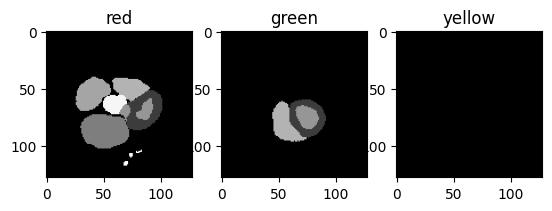

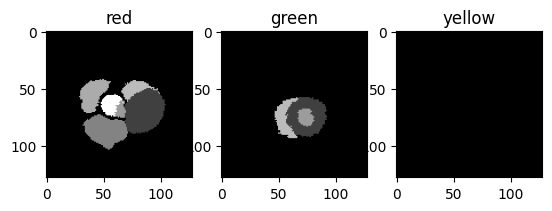

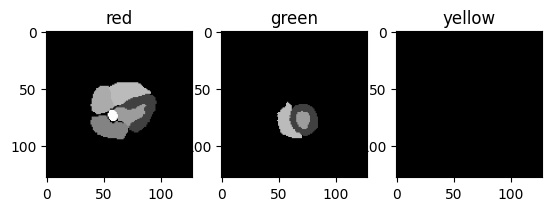

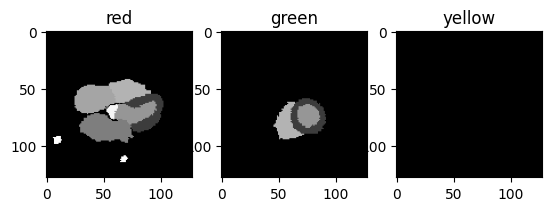

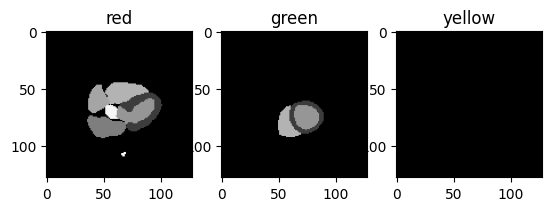

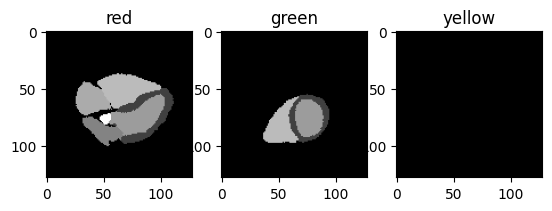

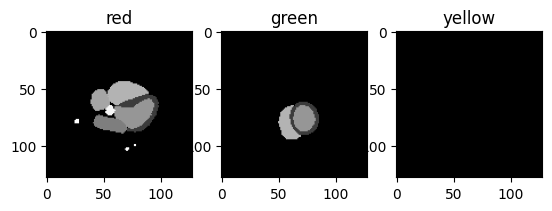

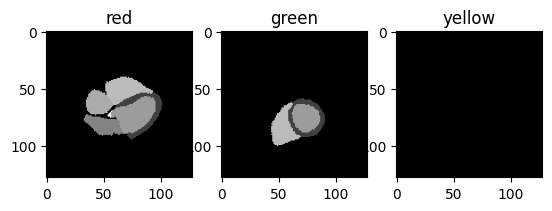

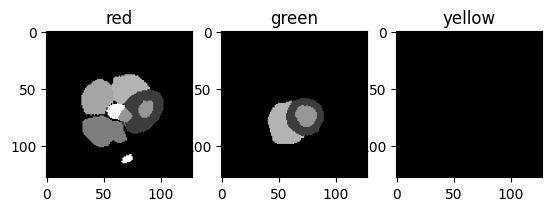

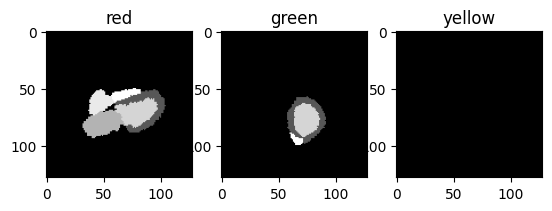

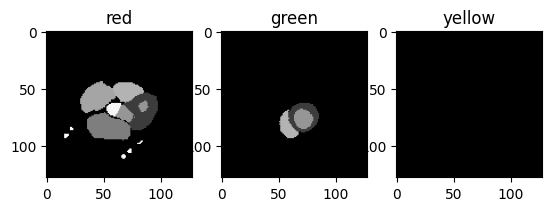

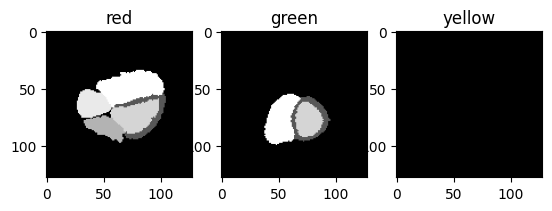

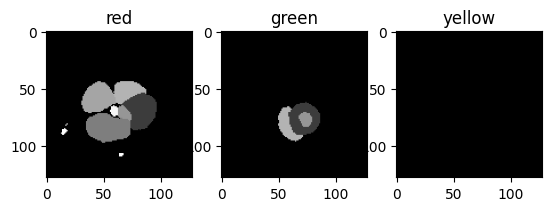

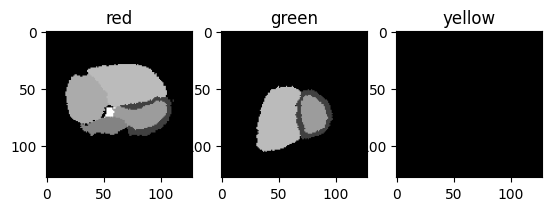

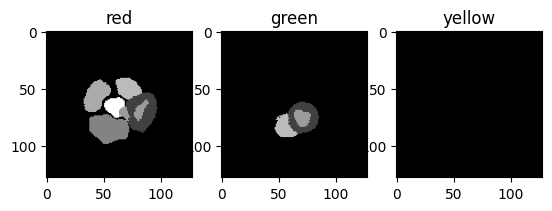

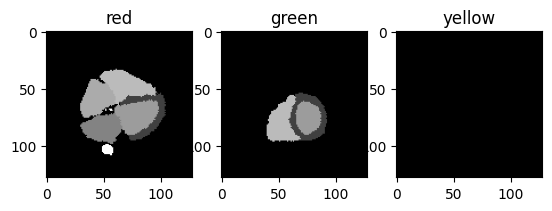

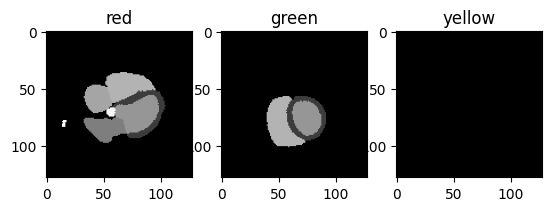

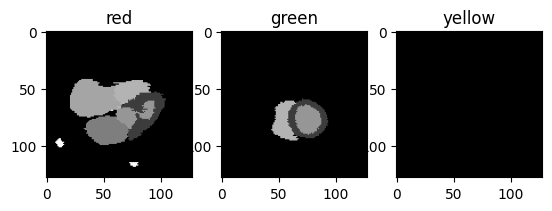

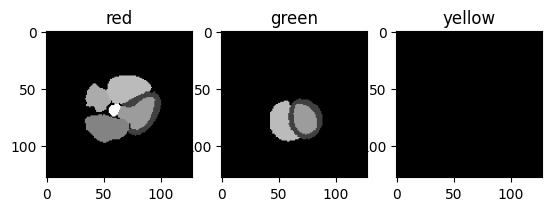

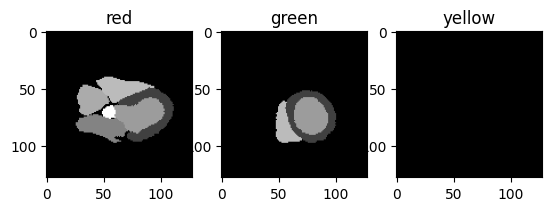

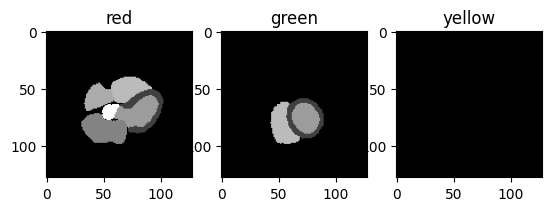

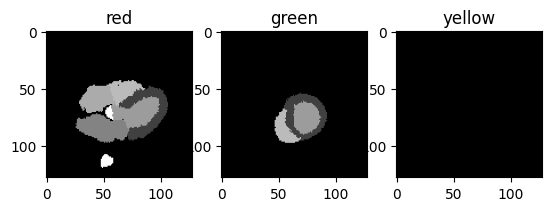

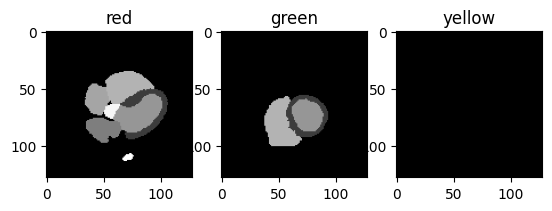

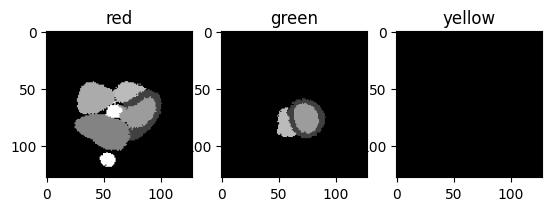

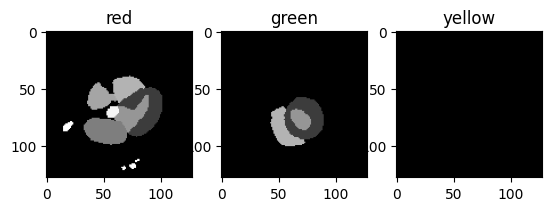

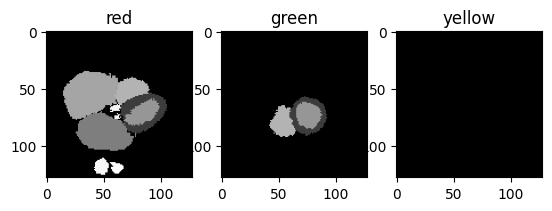

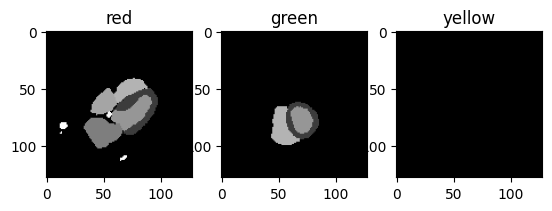

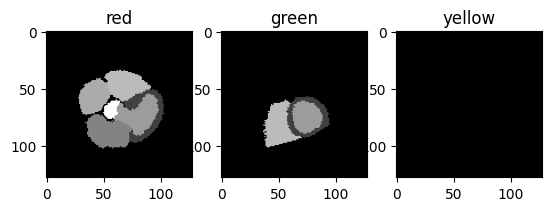

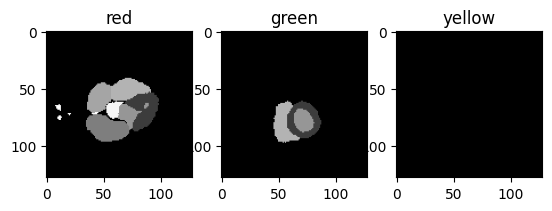

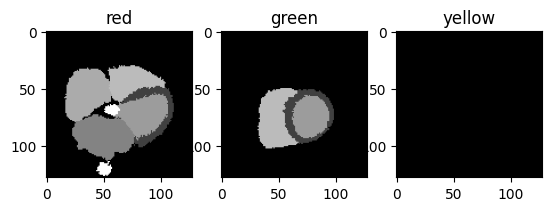

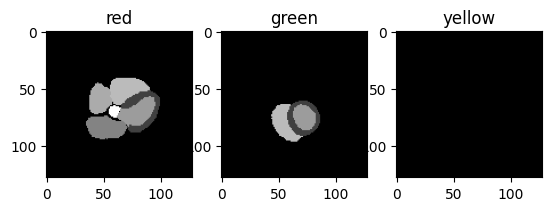

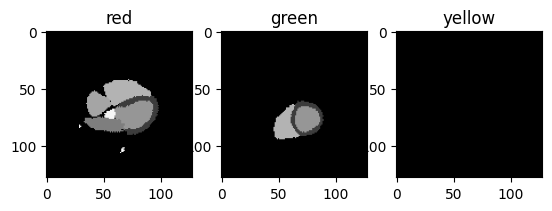

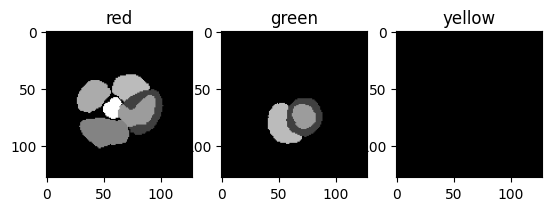

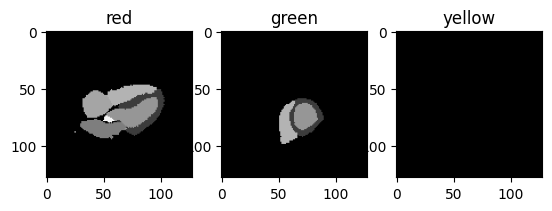

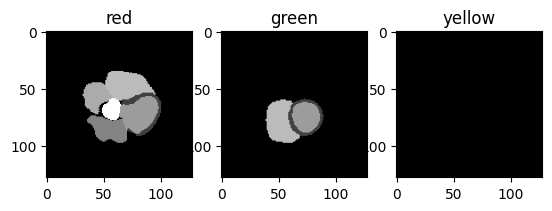

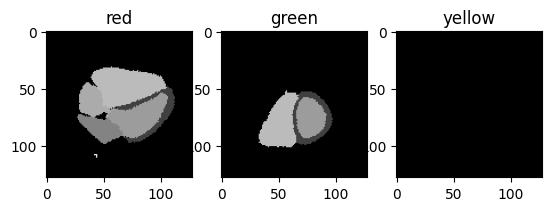

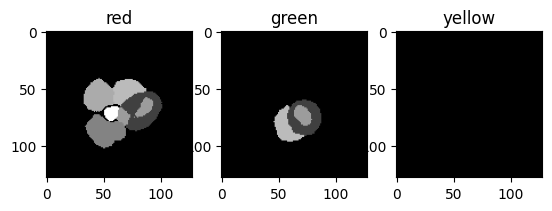

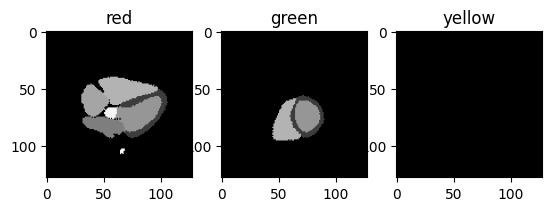

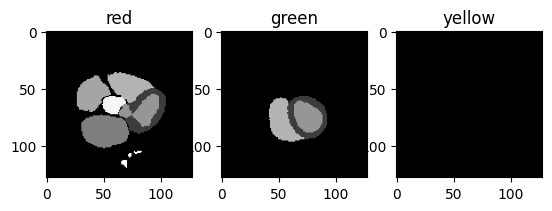

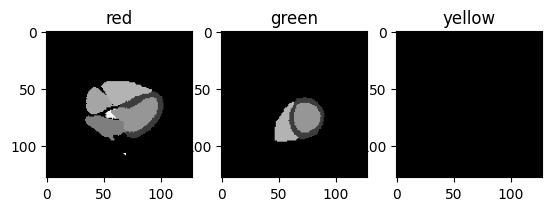

In [6]:
_4CH_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_4CH.mat"))
_SA_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA.mat"))

FOV_MM = torch.tensor([224,224,224])
FOV_VOX = torch.tensor([128,128,128])

for p_id in range(1001,1021):
    for mod_id in ['ct', 'mr']:
        mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_train_selection/{mod_id}_train_selection_{p_id}_image.nii.gz")
        mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_train_selection/{mod_id}_train_selection_{p_id}_label.nii.gz")

        if not (mri_path.is_file() and mri_gt_path.is_file()): 
            mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_test_selection/{mod_id}_test_selection_{p_id}_image.nii.gz")
            mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_test_selection/{mod_id}_test_selection_{p_id}_label.nii.gz")

        nii = nib.load(mri_path)
        gt_nii = nib.load(mri_gt_path)

        align_mat = torch.from_numpy(np.loadtxt(Path(MMWHS_BASE_PATH, f"preprocessed/f1002mr_m{p_id}{mod_id}.mat")))
        hla_mat = align_mat @ _4CH_to_ras_mat
        sa_mat =  align_mat @ _SA_to_ras_mat

        data = torch.as_tensor(nii.get_fdata()).unsqueeze(0).unsqueeze(0)
        gt_data = torch.as_tensor(gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0)
        affine = torch.as_tensor(nii.affine)
        gt_affine = torch.as_tensor(gt_nii.affine)

        hla_volume, *_ = nifti_transform(data, affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX)
        hla_label, *_ = nifti_transform(gt_data, gt_affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)
        sa_volume, *_ = nifti_transform(data, affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX)
        sa_label, *_ = nifti_transform(gt_data, gt_affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)

        hla_slc = cut_slice(hla_label).squeeze()
        sa_slc = cut_slice(sa_label).squeeze()

        plot_slices(hla_slc, sa_slc, torch.zeros_like(sa_slc), vmax=hla_slc.max().item())

# Visualize HLA and SA view (from prealigned images and labels)

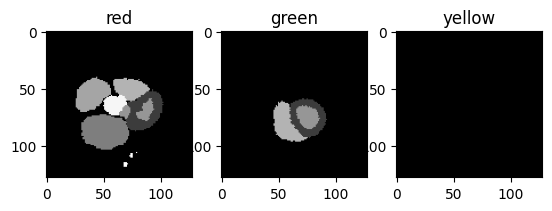

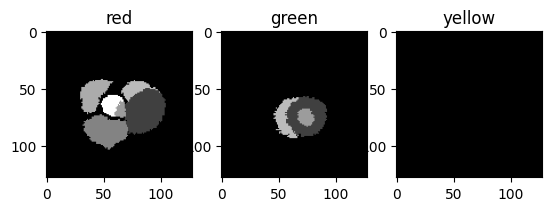

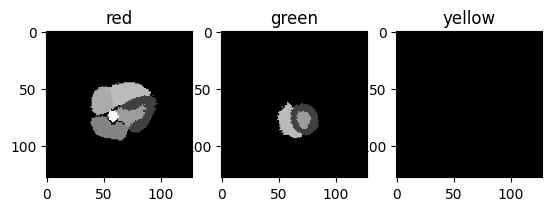

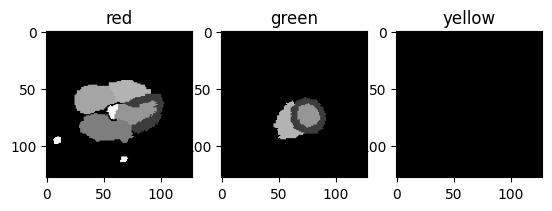

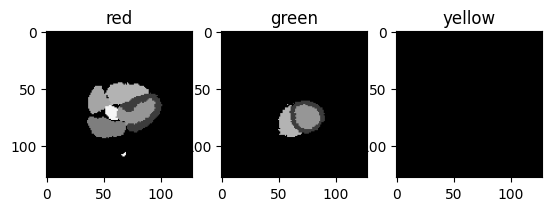

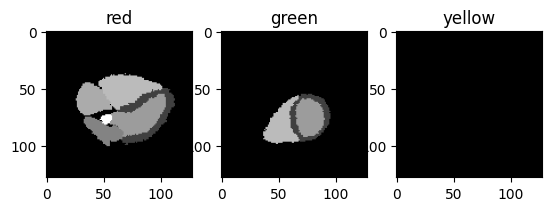

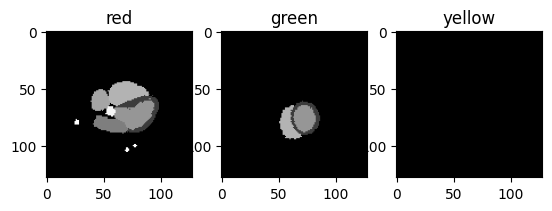

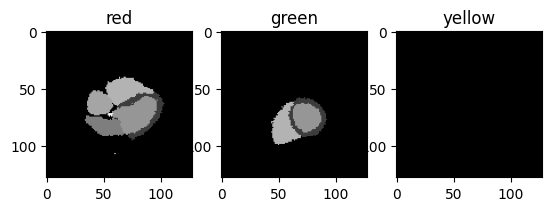

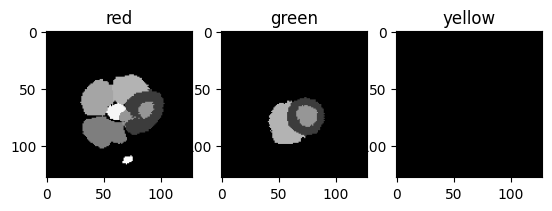

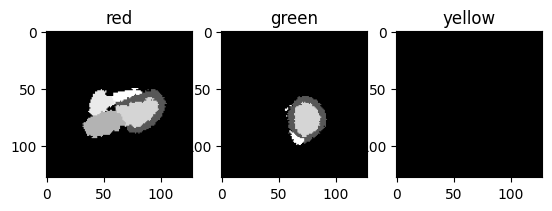

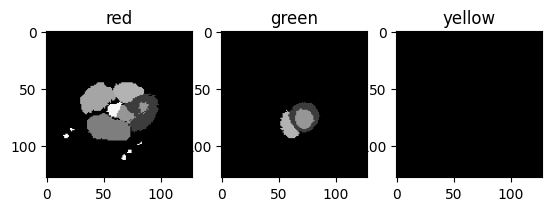

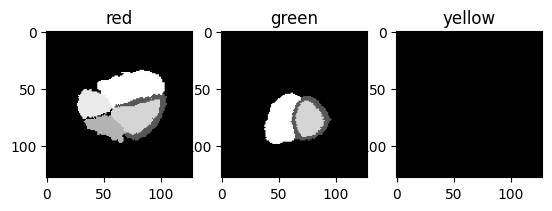

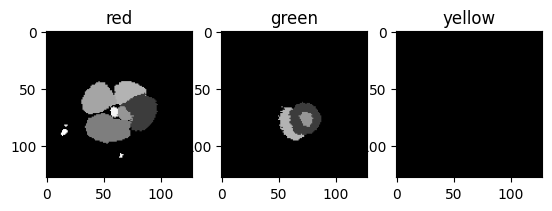

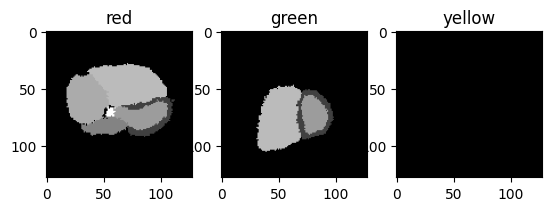

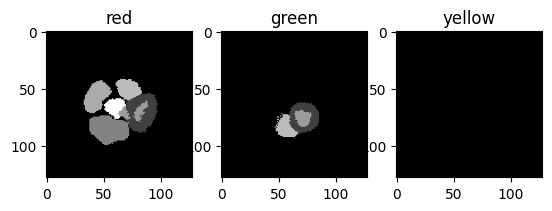

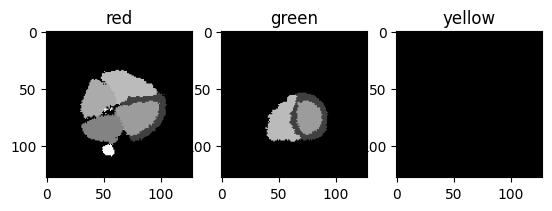

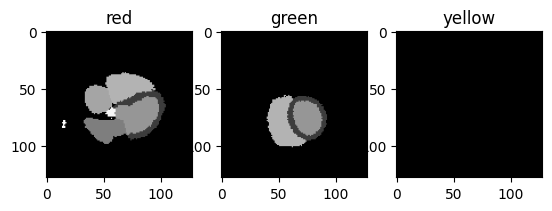

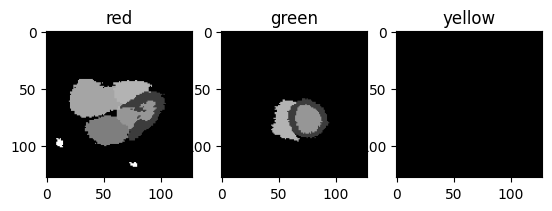

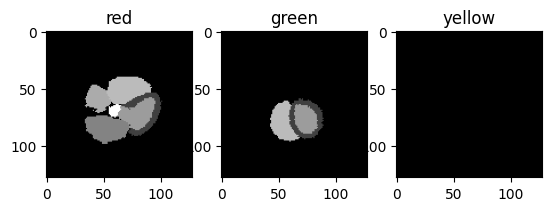

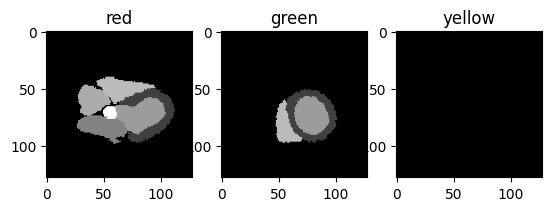

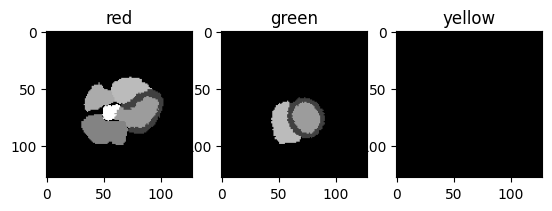

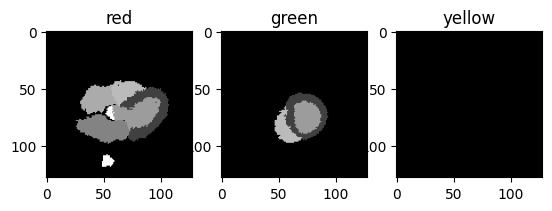

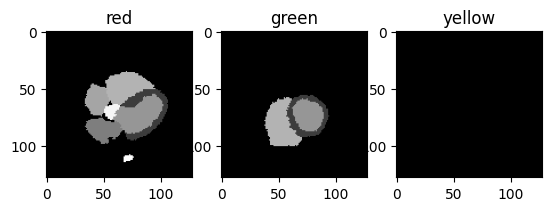

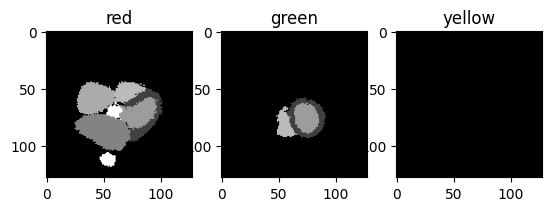

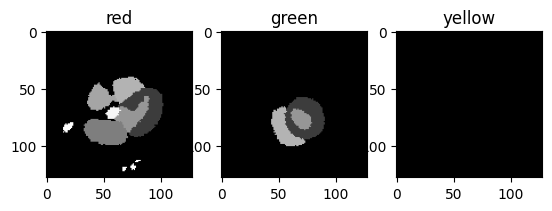

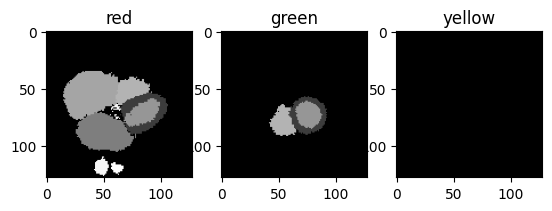

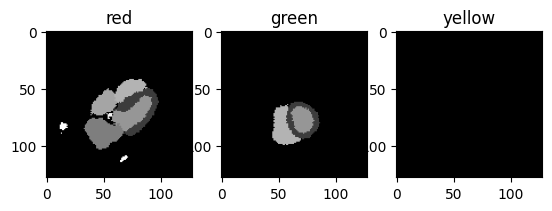

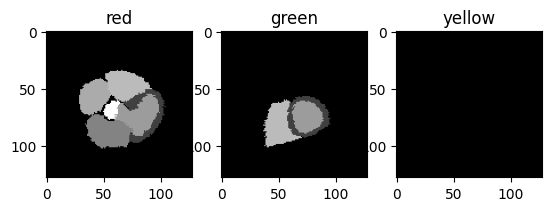

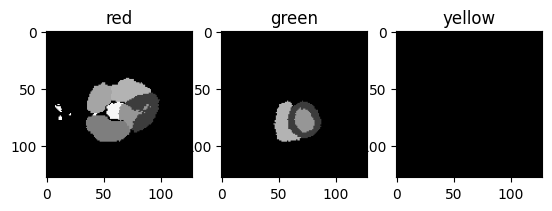

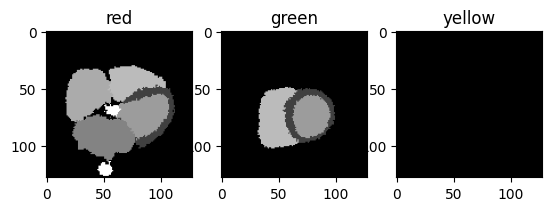

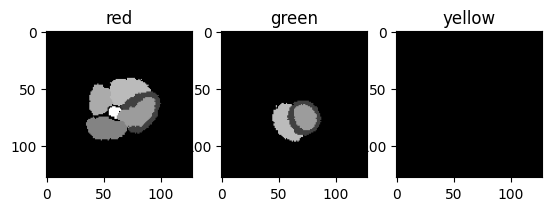

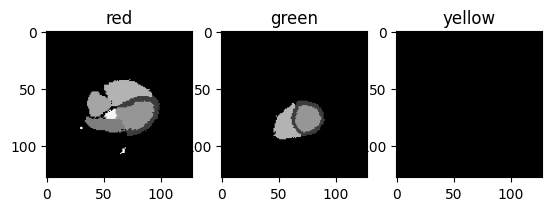

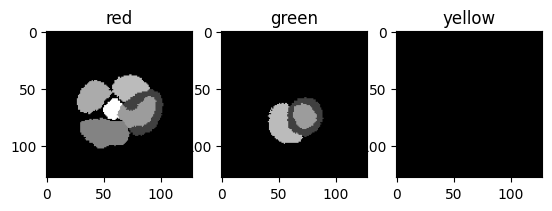

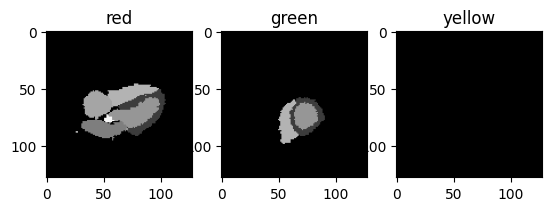

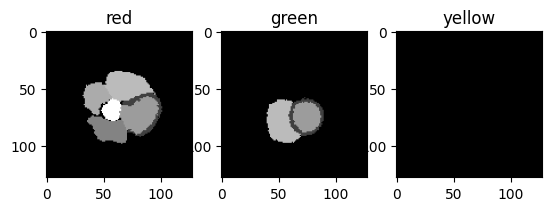

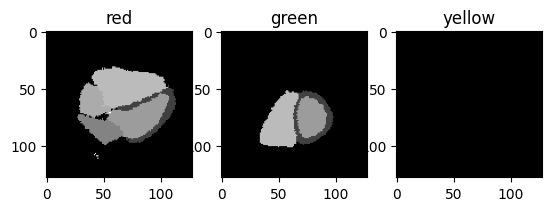

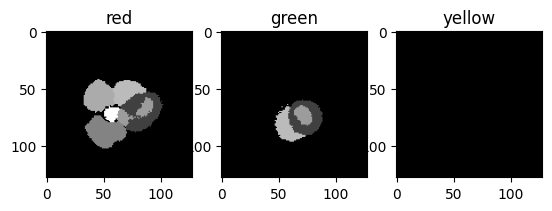

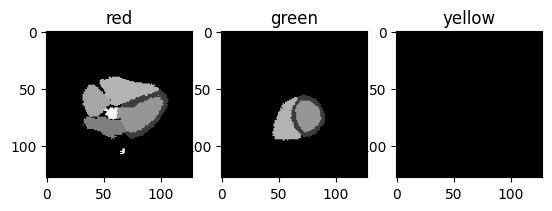

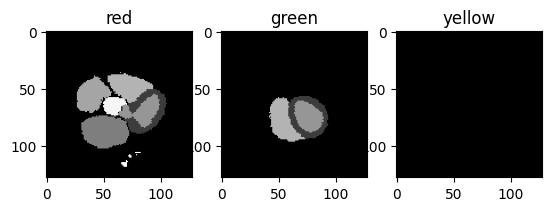

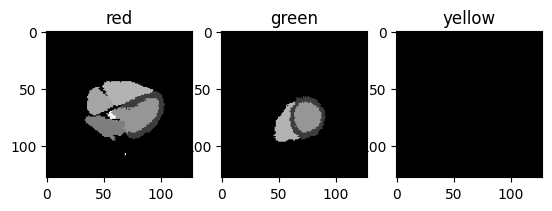

In [10]:
_4CH_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_4CH.mat"))
_SA_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA.mat"))

FOV_MM = torch.tensor([224,224,224])
FOV_VOX = torch.tensor([128,128,128])

for p_id in range(1001,1021):
    for mod_id in ['ct', 'mr']:
        mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_image_registered.nii.gz")
        mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_label_registered.nii.gz")

        if not (mri_path.is_file() and mri_gt_path.is_file()): 
            mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_test_selection/{mod_id}_test_selection_{p_id}_image_registered.nii.gz")
            mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_test_selection/{mod_id}_test_selection_{p_id}_label_registered.nii.gz")

        nii = nib.load(mri_path)
        gt_nii = nib.load(mri_gt_path)

        hla_mat = _4CH_to_ras_mat
        sa_mat = _SA_to_ras_mat

        data = torch.as_tensor(nii.get_fdata()).unsqueeze(0).unsqueeze(0)
        gt_data = torch.as_tensor(gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0)
        affine = torch.as_tensor(nii.affine)
        gt_affine = torch.as_tensor(gt_nii.affine)

        hla_volume, *_ = nifti_transform(data, affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX)
        hla_label, *_ = nifti_transform(gt_data, gt_affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)
        sa_volume, *_ = nifti_transform(data, affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX)
        sa_label, *_ = nifti_transform(gt_data, gt_affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)

        hla_slc = cut_slice(hla_label).squeeze()
        sa_slc = cut_slice(sa_label).squeeze()

        plot_slices(hla_slc, sa_slc, torch.zeros_like(sa_slc), vmax=hla_slc.max().item())

# Create low-res prescans

In [12]:
LOWRES_MM = [2.,2.,5.]

LOWRES_MM = [f"{p:.2f}" for p in LOWRES_MM]

for p_id in trange(1001,1021):
    for mod_id in ['ct', 'mr']:
        mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_image_registered.nii.gz")
        mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_label_registered.nii.gz")

        if not (mri_path.is_file() and mri_gt_path.is_file()): 
            mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_test_selection/{mod_id}_train_selection_{p_id}_image_registered.nii.gz")
            mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_test_selection/{mod_id}_train_selection_{p_id}_label_registered.nii.gz")
        
        output_mri_path = Path(
            str(mri_path)
            .replace("_registered_train", "_registered_train_lowres")
            .replace("_registered_test_selection", "_registered_test_selection_lowres")
            .replace("registered.nii.gz", "registered_lowres.nii.gz")
        )

        output_mri_gt_path = Path(
            str(mri_gt_path)
            .replace("_registered_train", "_registered_train_lowres")
            .replace("_registered_test_selection", "_registered_test_selection_lowres")
            .replace("registered.nii.gz", "registered_lowres.nii.gz")
        )

        output_mri_path.parent.mkdir(exist_ok=True, parents=True)
        !{c3d} {mri_path} -resample-mm {"x".join(LOWRES_MM)}mm -o {output_mri_path}
        !{c3d} {mri_gt_path} -interpolation NearestNeighbor -resample-mm {"x".join(LOWRES_MM)}mm -type int -o {output_mri_gt_path}

  0%|          | 0/20 [00:00<?, ?it/s]715.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
721.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
727.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
733.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
  5%|▌         | 1/20 [00:23<07:34, 23.93s/it]739.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
745.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
751.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
757.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
 10%|█         | 2/20 [00:48<07:12, 24.05s/it]763.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
769.52s - pydevd: Sendin

# Retrieve hires 2D views from volumes

In [4]:
def get_slice_params(optim_output_path, view, epoch_idx):
    param_paths = []

    for epoch_idx in range(epoch_idx-3, epoch_idx+1):
        param_paths.extend(list(Path(optim_output_path).glob(f"{view}_params*{epoch_idx}.pt")))

    param_paths = sorted(list(param_paths))
    print(param_paths)

    optimal_params = defaultdict(lambda: {})

    for p in param_paths:
        params = torch.load(p)
        epx_theta_aps = optimal_params[f'epx_{view}_theta_aps']
        epx_theta_aps.update(params[f'epx_{view}_theta_aps'])
        optimal_params[f'epx_{view}_theta_aps'] = epx_theta_aps

        epx_theta_t_offsets = optimal_params[f'epx_{view}_theta_t_offsets']
        epx_theta_t_offsets.update(params[f'epx_{view}_theta_t_offsets'])
        optimal_params[f'epx_{view}_theta_t_offsets'] = epx_theta_t_offsets

        epx_sa_theta_zps = optimal_params[f'epx_{view}_theta_zps']
        epx_sa_theta_zps.update(params[f'epx_{view}_theta_zps'])
        optimal_params[f'epx_{view}_theta_zps'] = epx_sa_theta_zps

    return optimal_params

In [5]:
def replace_label_values(label):
    # Replace label numbers with MMWHS equivalent
    # STRUCTURE           MMWHS   ACDC    NNUNET
    # background          0       0       0
    # left_myocardium     205     2       1
    # left_atrium         420     N/A     2
    # ?                   421     N/A     N/A
    # left_ventricle      500     3       3
    # right_atrium        550     N/A     4
    # right_ventricle     600     1       5
    # ascending_aorta     820     N/A     6
    # pulmonary_artery    850     N/A     7
    orig_values = [0,  205, 420, 421, 500, 550, 600, 820, 850]
    new_values = [0,  1,   2,   0,   3,   4,   5,   0,   0]

    modified_label = label.clone()
    for orig, new in zip(orig_values, new_values):
        modified_label[modified_label == orig] = new
    return modified_label

def get_theta_t_from_offsets(theta_t_offsets):
    B=1
    theta_t = torch.cat([theta_t_offsets, torch.ones(B).view(B,1)], dim=1)
    theta_t = torch.cat([
        torch.eye(4)[:4,:3].view(1,4,3).repeat(B,1,1),
        theta_t.view(B,4,1)
        ], dim=-1)

    return theta_t

In [6]:
def replace_slice_paths(_path, output_name, ornt, aug_idx=None):
    aug_postfix = f"_aug-{aug_idx}" if aug_idx is not None else ''
    new_path = Path(
    str(_path)
        .replace("_registered_train_selection", f"_train_selection_{output_name}_slices")
        .replace("_registered_test_selection", f"_test_selection_{output_name}_slices")
        .replace("registered.nii.gz", f"{output_name}_slice_{ornt}{aug_postfix}.nii.gz")
    )
    return new_path

def replace_volume_paths(_path, output_name, ornt, aug_idx=None):
    aug_postfix = f"_aug-{aug_idx}" if aug_idx is not None else ''
    new_path = Path(
    str(_path)
        .replace("_registered_train_selection", f"_train_selection_{output_name}_volumes")
        .replace("_registered_test_selection", f"_test_selection_{output_name}_volumes")
        .replace("registered.nii.gz", f"{output_name}_volume_{ornt}{aug_postfix}.nii.gz")
    )
    return new_path

In [7]:
def get_init_affines(_path):
    sa_st_dict = torch.load(Path(_path) / "sa_atm.pth", map_location='cpu')
    hla_st_dict = torch.load(Path(_path) / "hla_atm.pth", map_location='cpu')

    sa_init_theta_a = compute_rotation_matrix_from_ortho6d(sa_st_dict['init_theta_ap'].view(1,6))[0].view(1,4,4).double()
    hla_init_theta_a = compute_rotation_matrix_from_ortho6d(hla_st_dict['init_theta_ap'].view(1,6))[0].view(1,4,4).double()
    return sa_init_theta_a, hla_init_theta_a

Processing: fold-0
[PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_stilted-tree-996_stage-3_fold-0/sa_params_train_epx_156.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_stilted-tree-996_stage-3_fold-0/sa_params_train_epx_157.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_stilted-tree-996_stage-3_fold-0/sa_params_train_epx_158.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_stilted-tree-996_stage-3_fold-0/sa_params_train_epx_159.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_stilted-tree-996_stage-3_fold-0/sa_params_val_epx_156.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_stilted-tree-996_stage-3_fold-0/sa_params_val_epx_157.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_stilted-tree-996_stage-3_fold-0/sa_params_val_epx_158.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_stilted-tree-996_stage-3_fold-0/sa_param

  0%|          | 0/20 [00:00<?, ?it/s]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


  5%|▌         | 1/20 [01:30<28:43, 90.73s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 10%|█         | 2/20 [03:10<28:47, 95.96s/it]

Mode: RETRIEVE_BASE_SLICES


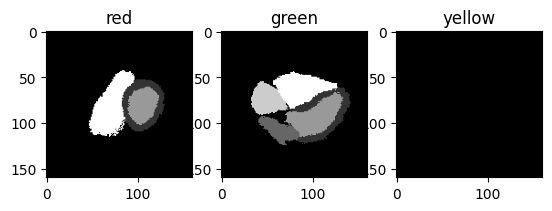

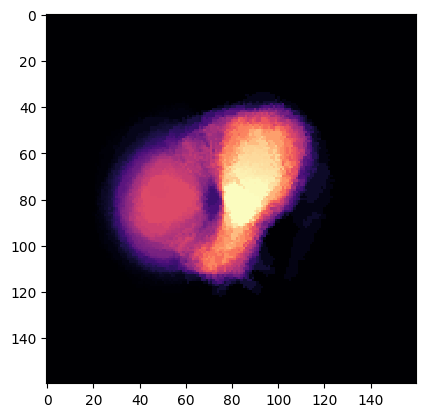

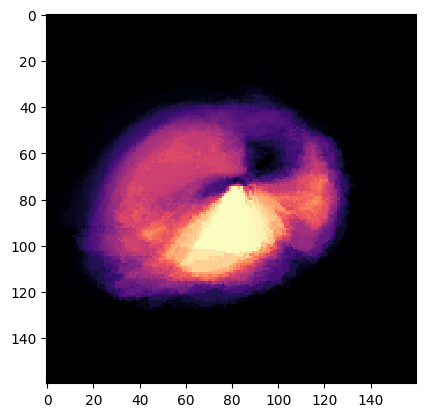

Mode: RETRIEVE_BASE_PLUS_INIT_SLICES


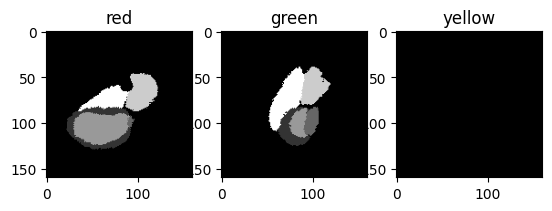

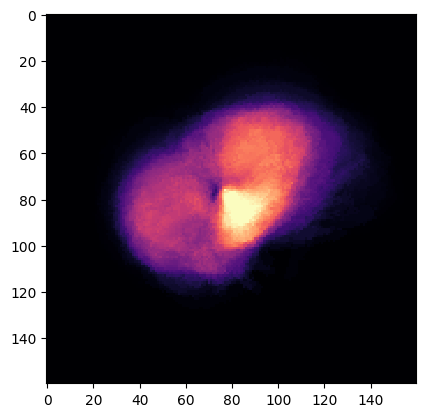

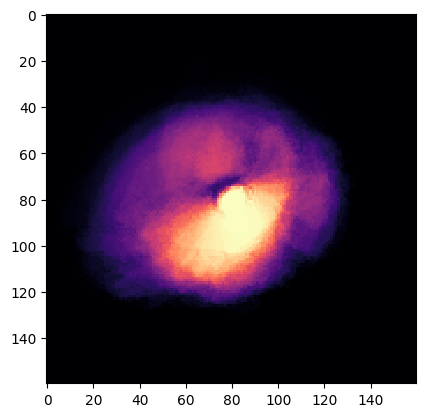

Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


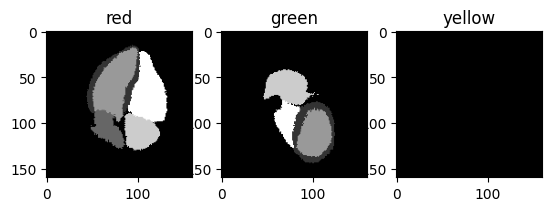

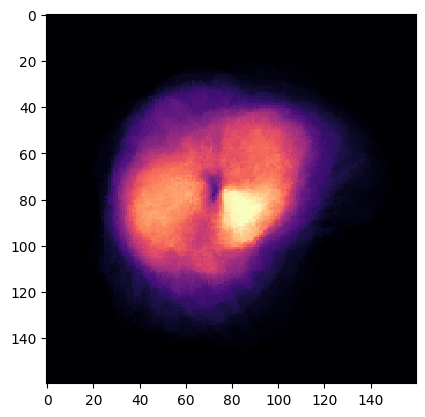

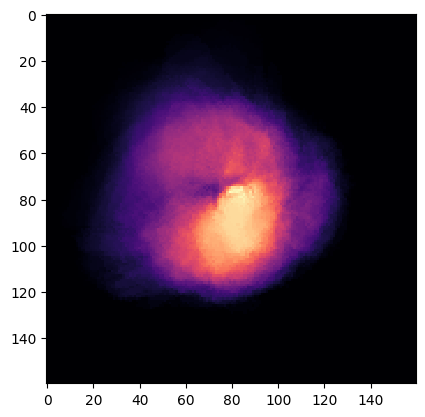

 15%|█▌        | 3/20 [04:43<26:46, 94.52s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 20%|██        | 4/20 [06:09<24:17, 91.11s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 25%|██▌       | 5/20 [07:27<21:36, 86.46s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 30%|███       | 6/20 [08:57<20:27, 87.69s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 35%|███▌      | 7/20 [10:18<18:32, 85.57s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 40%|████      | 8/20 [11:56<17:55, 89.58s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 45%|████▌     | 9/20 [13:25<16:21, 89.24s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 50%|█████     | 10/20 [14:53<14:51, 89.10s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 55%|█████▌    | 11/20 [16:20<13:14, 88.31s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 60%|██████    | 12/20 [17:54<12:00, 90.11s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 65%|██████▌   | 13/20 [19:19<10:20, 88.61s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 70%|███████   | 14/20 [20:39<08:34, 85.75s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 75%|███████▌  | 15/20 [21:58<06:59, 83.91s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 80%|████████  | 16/20 [23:31<05:46, 86.53s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 85%|████████▌ | 17/20 [25:11<04:31, 90.56s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 90%|█████████ | 18/20 [26:42<03:01, 90.84s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 95%|█████████▌| 19/20 [28:44<01:40, 100.23s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


100%|██████████| 20/20 [30:03<00:00, 90.19s/it] 


Processing: fold-1
[PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_blooming-universe-1000_stage-3_fold-1/sa_params_train_epx_156.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_blooming-universe-1000_stage-3_fold-1/sa_params_train_epx_157.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_blooming-universe-1000_stage-3_fold-1/sa_params_train_epx_158.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_blooming-universe-1000_stage-3_fold-1/sa_params_train_epx_159.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_blooming-universe-1000_stage-3_fold-1/sa_params_val_epx_156.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_blooming-universe-1000_stage-3_fold-1/sa_params_val_epx_157.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_blooming-universe-1000_stage-3_fold-1/sa_params_val_epx_158.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_3

  0%|          | 0/20 [00:00<?, ?it/s]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


  5%|▌         | 1/20 [01:33<29:41, 93.76s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 10%|█         | 2/20 [02:56<26:06, 87.05s/it]

Mode: RETRIEVE_BASE_SLICES


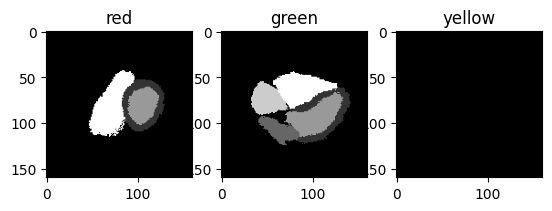

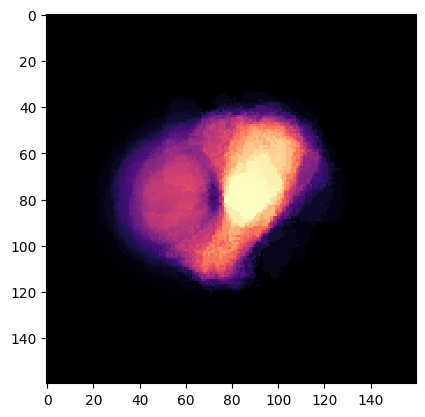

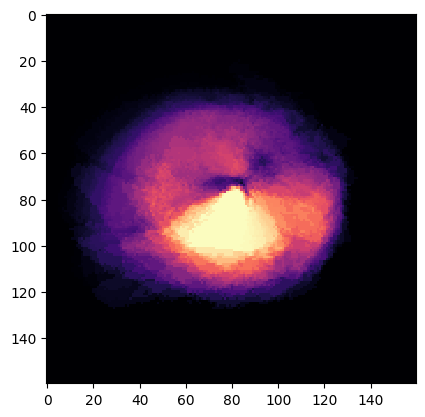

Mode: RETRIEVE_BASE_PLUS_INIT_SLICES


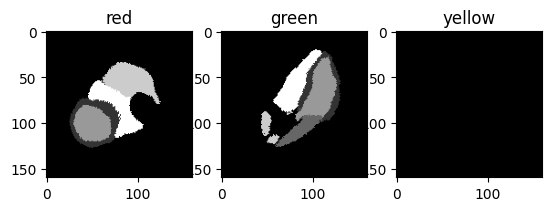

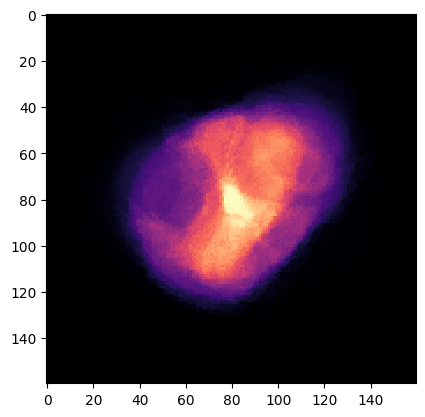

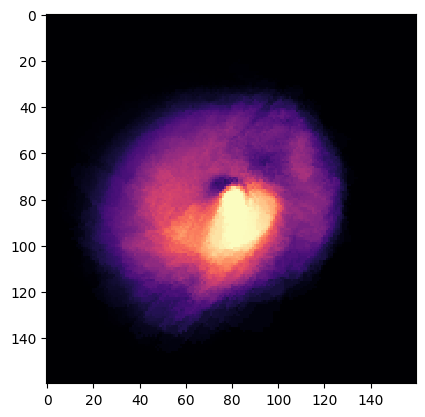

Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


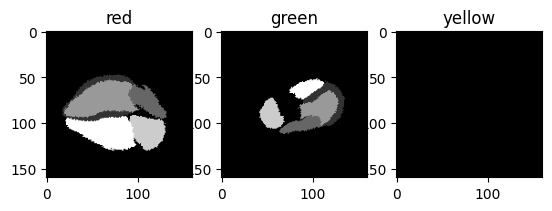

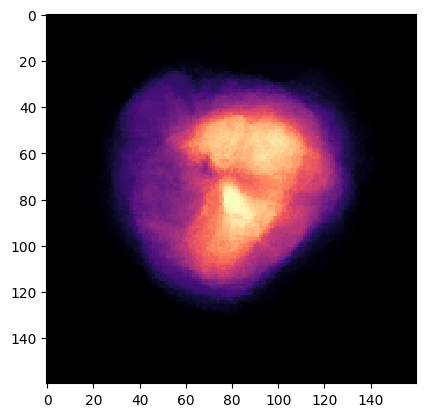

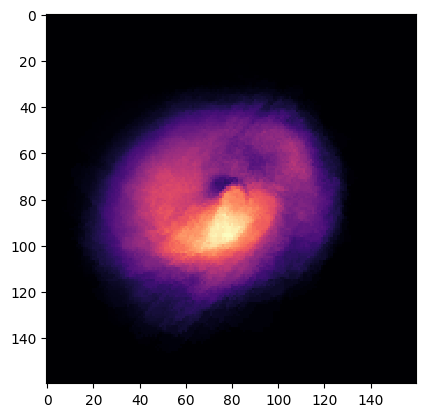

 15%|█▌        | 3/20 [04:21<24:26, 86.29s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 20%|██        | 4/20 [05:50<23:17, 87.37s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 25%|██▌       | 5/20 [07:21<22:12, 88.84s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 30%|███       | 6/20 [09:05<21:53, 93.82s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 35%|███▌      | 7/20 [10:26<19:26, 89.71s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 40%|████      | 8/20 [11:53<17:46, 88.88s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 45%|████▌     | 9/20 [13:23<16:20, 89.13s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 50%|█████     | 10/20 [14:54<14:57, 89.71s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 55%|█████▌    | 11/20 [16:20<13:16, 88.47s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 60%|██████    | 12/20 [18:14<12:51, 96.49s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 65%|██████▌   | 13/20 [19:40<10:52, 93.21s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 70%|███████   | 14/20 [21:13<09:19, 93.21s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 75%|███████▌  | 15/20 [22:43<07:41, 92.26s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 80%|████████  | 16/20 [24:36<06:33, 98.35s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 85%|████████▌ | 17/20 [26:01<04:43, 94.51s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 90%|█████████ | 18/20 [27:44<03:13, 96.91s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 95%|█████████▌| 19/20 [29:16<01:35, 95.31s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


100%|██████████| 20/20 [31:03<00:00, 93.16s/it]


Processing: fold-2
[PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_vital-vortex-1004_stage-3_fold-2/sa_params_train_epx_156.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_vital-vortex-1004_stage-3_fold-2/sa_params_train_epx_157.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_vital-vortex-1004_stage-3_fold-2/sa_params_train_epx_158.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_vital-vortex-1004_stage-3_fold-2/sa_params_train_epx_159.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_vital-vortex-1004_stage-3_fold-2/sa_params_val_epx_156.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_vital-vortex-1004_stage-3_fold-2/sa_params_val_epx_157.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_vital-vortex-1004_stage-3_fold-2/sa_params_val_epx_158.pt'), PosixPath('/shared/slice_inflate/data/output/20230704__19_48_35_vital-vortex-1004_stage-3_fold-2/

  0%|          | 0/20 [00:00<?, ?it/s]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


  5%|▌         | 1/20 [03:09<1:00:01, 189.56s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 10%|█         | 2/20 [06:33<59:21, 197.89s/it]  

Mode: RETRIEVE_BASE_SLICES


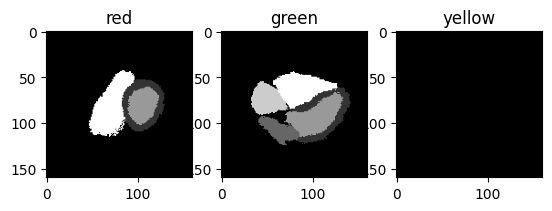

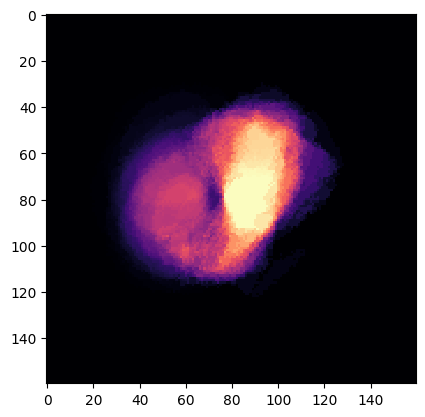

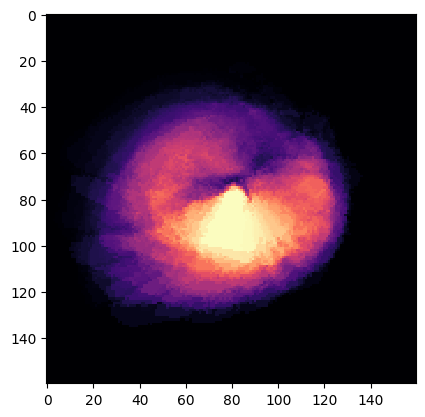

Mode: RETRIEVE_BASE_PLUS_INIT_SLICES


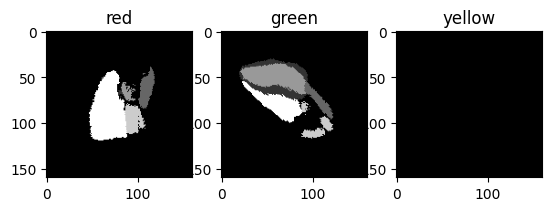

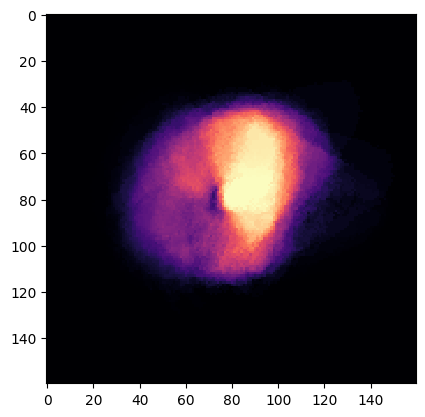

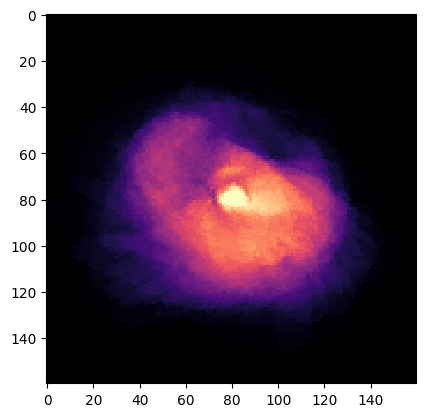

Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


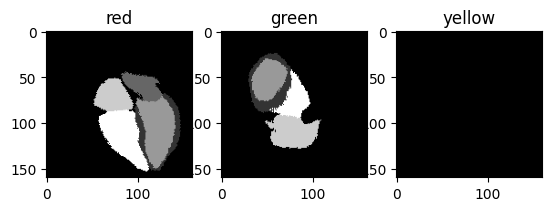

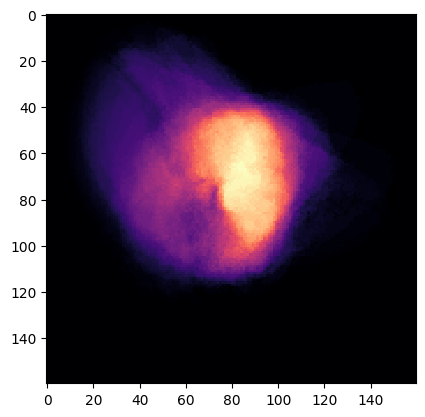

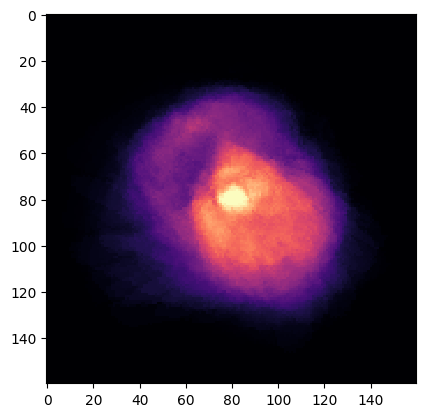

 15%|█▌        | 3/20 [09:58<57:01, 201.27s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 20%|██        | 4/20 [13:02<51:48, 194.28s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 25%|██▌       | 5/20 [14:37<39:40, 158.73s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 30%|███       | 6/20 [16:03<31:16, 134.06s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 35%|███▌      | 7/20 [17:32<25:48, 119.12s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 40%|████      | 8/20 [18:53<21:23, 107.00s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 45%|████▌     | 9/20 [20:18<18:21, 100.15s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 50%|█████     | 10/20 [21:31<15:17, 91.76s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 55%|█████▌    | 11/20 [22:57<13:30, 90.07s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 60%|██████    | 12/20 [24:21<11:45, 88.22s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 65%|██████▌   | 13/20 [25:58<10:36, 90.96s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 70%|███████   | 14/20 [27:28<09:02, 90.41s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 75%|███████▌  | 15/20 [28:51<07:20, 88.17s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 80%|████████  | 16/20 [30:06<05:37, 84.45s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 85%|████████▌ | 17/20 [31:31<04:13, 84.44s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 90%|█████████ | 18/20 [32:48<02:44, 82.13s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


 95%|█████████▌| 19/20 [34:12<01:22, 82.89s/it]

Mode: RETRIEVE_BASE_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_SLICES
Mode: RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES


100%|██████████| 20/20 [35:37<00:00, 106.88s/it]


In [14]:
MODE_DICT = dict(
    RETRIEVE_BASE_SLICES=True,
    RETRIEVE_BASE_PLUS_INIT_SLICES=True,
    RETRIEVE_BASE_PLUS_INIT_PLUS_OPTIMIZED_SLICES=True,
)

DO_SAVE = True
NUM_AUGMENTATIONS = 20

MODEL_PATHS = {
    'fold-0': "/shared/slice_inflate/data/output/20230704__19_48_35_stilted-tree-996_stage-3_fold-0",
    'fold-1': "/shared/slice_inflate/data/output/20230704__19_48_35_blooming-universe-1000_stage-3_fold-1",
    'fold-2': "/shared/slice_inflate/data/output/20230704__19_48_35_vital-vortex-1004_stage-3_fold-2",
}

for model_key, optim_output_path in MODEL_PATHS.items():
    print("Processing:", model_key)
    optim_model_path = optim_output_path.replace('output/', 'models/') + "_best"

    _4CH_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_4CH.mat"))
    _SA_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA.mat"))

    FOV_MM = torch.tensor([224,224,224])
    FOV_VOX = torch.tensor([160,160,160])

    sa_sum = []
    hla_sum = []

    optimal_sa_params = get_slice_params(optim_output_path, 'sa', 159)
    optimal_hla_params = get_slice_params(optim_output_path, 'hla', 159)

    with torch.no_grad():
        for p_id in trange(1001,1021):
            for mod_id in ['mr']:
                mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_image_registered.nii.gz")
                mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_label_registered.nii.gz")

                if not (mri_path.is_file() and mri_gt_path.is_file()): 
                    mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_test_selection/{mod_id}_test_selection_{p_id}_image_registered.nii.gz")
                    mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_test_selection/{mod_id}_test_selection_{p_id}_label_registered.nii.gz")

                nii = nib.load(mri_path)
                gt_nii = nib.load(mri_gt_path)

                hla_mat = _4CH_to_ras_mat 
                sa_mat = _SA_to_ras_mat

                data = torch.as_tensor(nii.get_fdata()).unsqueeze(0).unsqueeze(0)
                gt_data = torch.as_tensor(gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0)
                affine = torch.as_tensor(nii.affine)
                gt_affine = torch.as_tensor(gt_nii.affine)

                gt_data = replace_label_values(gt_data)

                for mode_idx, (mode_name, do_mode) in enumerate(MODE_DICT.items()):
                    if not do_mode: continue

                    # Only output BASE slices ones for fold 0 (would all be the same for all folds)
                    if mode_idx > 0 and (not 'OPTIMIZED' in mode_name and not 'INIT' in mode_name): continue

                    print("Mode:", mode_name)

                    for aug_idx in range(NUM_AUGMENTATIONS+1):
                        aug_affine = init_sa_affine = init_hla_affine = opt_sa_affine_a = opt_hla_affine_a = opt_sa_affine_t = opt_hla_affine_t = torch.eye(4).view(1,4,4).double()
                        
                        replace_tag = f'hires_{optim_output_path.split("/")[-1]}'

                        if 'OPTIMIZED' in mode_name:
                            replace_tag = "optimized_slc_" + replace_tag
                        elif 'INIT' in mode_name:
                            replace_tag = "init_slc_" + replace_tag
                        else:
                            replace_tag = "base_slc_" + replace_tag            

                        if aug_idx > 0:
                            # aug_idx 0 is not augmented.
                            aug_affine = get_random_affine(rotation_strength=1.0).double()

                        if 'INIT' in mode_name:
                            # Initial affine of AffineTransformModule
                            init_sa_affine, init_hla_affine = get_init_affines(optim_model_path)

                        if 'OPTIMIZED' in mode_name:
                            # Optimized affines from parameters of AffineTransformModule 
                            opt_sa_affine_a = compute_rotation_matrix_from_ortho6d(optimal_sa_params['epx_sa_theta_aps'][f"{p_id}-{mod_id}"].view(1,6)).double().view(1,4,4)
                            opt_sa_affine_t = get_theta_t_from_offsets(optimal_sa_params['epx_sa_theta_t_offsets'][f"{p_id}-{mod_id}"].view(1,3)).double()
                            opt_hla_affine_a = compute_rotation_matrix_from_ortho6d(optimal_hla_params['epx_hla_theta_aps'][f"{p_id}-{mod_id}"].view(1,6)).double().view(1,4,4)
                            opt_hla_affine_t = get_theta_t_from_offsets(optimal_hla_params['epx_hla_theta_t_offsets'][f"{p_id}-{mod_id}"].view(1,3)).double()
                        
                        opt_sa_affine = aug_affine @ opt_sa_affine_a @ init_sa_affine
                        opt_sa_affine = opt_sa_affine @ opt_sa_affine_t
                        opt_hla_affine = aug_affine @ opt_hla_affine_a @ init_hla_affine
                        opt_hla_affine = opt_hla_affine @ opt_hla_affine_t

                        sa_volume, _, sa_affine = nifti_transform(data, affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, pre_grid_sample_affine=opt_sa_affine)
                        sa_label, _, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True, pre_grid_sample_affine=opt_sa_affine)
                        hla_volume, _, hla_affine = nifti_transform(data, affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, pre_grid_sample_affine=opt_hla_affine)
                        hla_label, _, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True, pre_grid_sample_affine=opt_hla_affine)

                        sa_label_crop_dummy = sa_label.clone()
                        sa_label_crop_dummy[:,:,0,0,0] = 999
                        sa_label_crop_dummy[:,:,-1,-1,-1] = 999
                        sa_label_slc, sa_image_slc, sa_slice_affine = crop_around_label_center(
                            label=sa_label_crop_dummy , vox_size=torch.tensor([-1,-1,1]), image=sa_volume, affine=sa_affine, 
                            center_mode='minmax'
                        )

                        hla_label_crop_dummy = hla_label.clone()
                        hla_label_crop_dummy[:,:,0,0,0] = 999
                        hla_label_crop_dummy[:,:,-1,-1,-1] = 999
                        hla_label_slc, hla_image_slc, hla_slice_affine = crop_around_label_center(
                            label=hla_label_crop_dummy , vox_size=torch.tensor([-1,-1,1]), image=hla_volume, affine=hla_affine, 
                            center_mode='minmax'
                        )
                        

                        # Squeeze all
                        hla_label, hla_volume = hla_label.flatten(0,2), hla_volume.flatten(0,2)
                        sa_label, sa_volume = sa_label.flatten(0,2), sa_volume.flatten(0,2)

                        hla_label_slc, hla_image_slc = hla_label_slc.flatten(0,2), hla_image_slc.flatten(0,2)
                        sa_label_slc, sa_image_slc = sa_label_slc.flatten(0,2), sa_image_slc.flatten(0,2)

                        hla_affine, hla_slice_affine = hla_affine.flatten(0,1), hla_slice_affine.flatten(0,1)
                        sa_affine, sa_slice_affine = sa_affine.flatten(0,1), sa_slice_affine.flatten(0,1)

                        if DO_SAVE:
                            # Save volumes
                            if aug_idx == 0 and False:
                                output_sa_image_volume_path = replace_volume_paths(mri_path, replace_tag, 'sa', aug_idx=aug_idx)
                                output_hla_image_volume_path = replace_volume_paths(mri_path, replace_tag, 'hla', aug_idx=aug_idx)
                                output_sa_label_volume_path = replace_volume_paths(mri_gt_path, replace_tag, 'sa', aug_idx=aug_idx)
                                output_hla_label_volume_path = replace_volume_paths(mri_gt_path, replace_tag, 'hla', aug_idx=aug_idx)

                                # Only save one volume (unaugmented)
                                output_hla_image_volume_path.parent.mkdir(exist_ok=True, parents=True)
                                # print("Storing volumes to:", output_hla_image_volume_path)
                                # Save image volumes
                                nib.save(nib.Nifti1Image(hla_volume.numpy(), affine=hla_affine.numpy()), output_hla_image_volume_path)
                                nib.save(nib.Nifti1Image(sa_volume.numpy(), affine=sa_affine.numpy()), output_sa_image_volume_path)
                                # Save label volumes
                                nib.save(nib.Nifti1Image(hla_label.numpy(), affine=hla_affine.numpy()), output_hla_label_volume_path)
                                nib.save(nib.Nifti1Image(sa_label.numpy(), affine=sa_affine.numpy()), output_sa_label_volume_path)

                            # Save slices
                            output_sa_image_slice_path = replace_slice_paths(mri_path, replace_tag, 'sa', aug_idx=aug_idx)
                            output_hla_image_slice_path = replace_slice_paths(mri_path, replace_tag, 'hla', aug_idx=aug_idx)
                            output_sa_label_slice_path = replace_slice_paths(mri_gt_path, replace_tag, 'sa', aug_idx=aug_idx)
                            output_hla_label_slice_path = replace_slice_paths(mri_gt_path, replace_tag, 'hla', aug_idx=aug_idx)

                            output_hla_image_slice_path.parent.mkdir(exist_ok=True, parents=True)
                            # print("Storing slices to:", output_hla_image_volume_path)
                            # Save image slices
                            nib.save(nib.Nifti1Image(hla_image_slc.numpy(), affine=hla_affine.numpy()), output_hla_image_slice_path)
                            nib.save(nib.Nifti1Image(sa_image_slc.numpy(), affine=sa_affine.numpy()), output_sa_image_slice_path)
                            # Save label slices
                            nib.save(nib.Nifti1Image(hla_label_slc.int().numpy(), affine=hla_affine.numpy()), output_hla_label_slice_path)
                            nib.save(nib.Nifti1Image(sa_label_slc.int().numpy(), affine=sa_affine.numpy()), output_sa_label_slice_path)
                    
                        if p_id == 1003:
                            if aug_idx == 0:
                                plot_slices(sa_label_slc.squeeze(), hla_label_slc.squeeze(), torch.zeros_like(sa_label_slc.squeeze()), vmax=hla_label_slc.max().item())
                                plt.show()
                                
                            if 'train' in str(mri_path):
                                sa_sum.append(sa_label_slc.squeeze())
                                hla_sum.append(hla_label_slc.squeeze())
                        # AUG LOOP END

                    if p_id == 1003:
                        plt.imshow(torch.stack(sa_sum, dim=0).sum(0).numpy().T, cmap='magma', interpolation='none')
                        plt.show()

                        plt.imshow(torch.stack(hla_sum, dim=0).sum(0).numpy().T, cmap='magma', interpolation='none')
                        plt.show()


# Retrieve optimized augmented slices (integrated above)

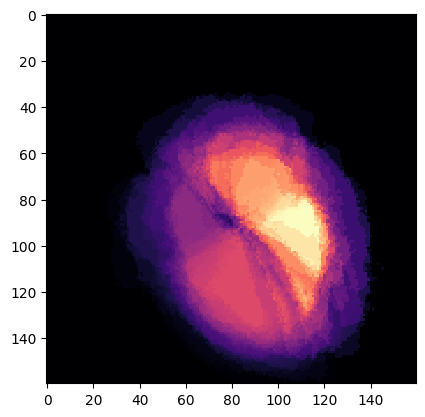

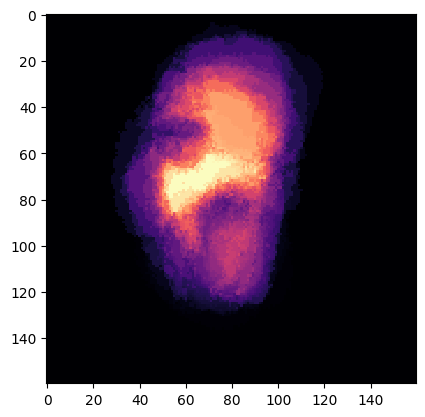

In [19]:
# DO_SAVE = True
# _4CH_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_4CH.mat"))
# _SA_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA.mat"))

# FOV_MM = torch.tensor([224,224,224])
# FOV_VOX = torch.tensor([160,160,160])

# sa_sum = []
# hla_sum = []

# with torch.no_grad():
#     for p_id in range(1001,1021):
#         for mod_id in ['mr']:
#             mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_image_registered.nii.gz")
#             mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_label_registered.nii.gz")

#             if not (mri_path.is_file() and mri_gt_path.is_file()): 
#                 # Do not augment test data
#                 continue

#             nii = nib.load(mri_path)
#             gt_nii = nib.load(mri_gt_path)

#             hla_mat = _4CH_to_ras_mat 
#             sa_mat = _SA_to_ras_mat

#             data = torch.as_tensor(nii.get_fdata()).unsqueeze(0).unsqueeze(0)
#             gt_data = torch.as_tensor(gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0)
#             affine = torch.as_tensor(nii.affine)
#             gt_affine = torch.as_tensor(gt_nii.affine)

#             gt_data = replace_label_values(gt_data)

#             # Calculate affines
#             opt_sa_affine = compute_rotation_matrix_from_ortho6d(optimal_sa_params['epx_sa_theta_aps'][f"{p_id}-{mod_id}"].view(1,6)).double().view(1,4,4)
#             opt_sa_affine = opt_sa_affine @ get_theta_t_from_offsets(optimal_sa_params['epx_sa_theta_t_offsets'][f"{p_id}-{mod_id}"].view(1,3)).double()

#             opt_hla_affine = compute_rotation_matrix_from_ortho6d(optimal_hla_params['epx_hla_theta_aps'][f"{p_id}-{mod_id}"].view(1,6)).double().view(1,4,4)
#             opt_hla_affine = opt_hla_affine @ get_theta_t_from_offsets(optimal_hla_params['epx_hla_theta_t_offsets'][f"{p_id}-{mod_id}"].view(1,3)).double()

#             for aug_idx in range(20):
#                 aug_affine = get_random_affine(rotation_strength=0.5).double()

#                 hla_volume, _, hla_affine = nifti_transform(data, affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, 
#                     pre_grid_sample_affine=aug_affine @ opt_hla_affine)
#                 hla_label, _, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True, 
#                     pre_grid_sample_affine=aug_affine @ opt_hla_affine)
#                 sa_volume, _, sa_affine = nifti_transform(data, affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, 
#                     pre_grid_sample_affine=aug_affine @ opt_sa_affine)
#                 sa_label, _, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True, 
#                     pre_grid_sample_affine=aug_affine @ opt_sa_affine)

#                 # output_sa_image_volume_path = replace_volume_paths(mri_path, 'optimized_hires', 'sa', idx=aug_idx)
#                 # output_hla_image_volume_path = replace_volume_paths(mri_path, 'optimized_hires', 'hla', idx=aug_idx)
#                 # output_sa_label_volume_path = replace_volume_paths(mri_gt_path, 'optimized_hires', 'sa', idx=aug_idx)
#                 # output_hla_label_volume_path = replace_volume_paths(mri_gt_path, 'optimized_hires', 'hla', idx=aug_idx)

#                 output_sa_image_slice_path = replace_slice_paths(mri_path, 'optimized_hires', idx=aug_idx, ornt='sa')
#                 output_hla_image_slice_path = replace_slice_paths(mri_path, 'optimized_hires', idx=aug_idx, ornt='hla')
#                 output_sa_label_slice_path = replace_slice_paths(mri_gt_path, 'optimized_hires', idx=aug_idx, ornt='sa')
#                 output_hla_label_slice_path = replace_slice_paths(mri_gt_path, 'optimized_hires', idx=aug_idx, ornt='hla')

#                 hla_label_crop_dummy = hla_label.clone()
#                 hla_label_crop_dummy[:,:,0,0,0] = 999
#                 hla_label_crop_dummy[:,:,-1,-1,-1] = 999
#                 hla_label_slc, hla_image_slc, hla_slice_affine = crop_around_label_center(
#                     label=hla_label_crop_dummy , vox_size=torch.tensor([-1,-1,1]), image=hla_volume, affine=hla_affine, 
#                     center_mode='minmax'
#                 )
                
#                 sa_label_crop_dummy = sa_label.clone()
#                 sa_label_crop_dummy[:,:,0,0,0] = 999
#                 sa_label_crop_dummy[:,:,-1,-1,-1] = 999
#                 sa_label_slc, sa_image_slc, sa_slice_affine = crop_around_label_center(
#                     label=sa_label_crop_dummy , vox_size=torch.tensor([-1,-1,1]), image=sa_volume, affine=sa_affine, 
#                     center_mode='minmax'
#                 )

#                 # Squeeze all
#                 hla_label, hla_volume = hla_label.flatten(0,2), hla_volume.flatten(0,2)
#                 sa_label, sa_volume = sa_label.flatten(0,2), sa_volume.flatten(0,2)

#                 hla_label_slc, hla_image_slc = hla_label_slc.flatten(0,2), hla_image_slc.flatten(0,2)
#                 sa_label_slc, sa_image_slc = sa_label_slc.flatten(0,2), sa_image_slc.flatten(0,2)

#                 hla_affine, hla_slice_affine = hla_affine.flatten(0,1), hla_slice_affine.flatten(0,1)
#                 sa_affine, sa_slice_affine = sa_affine.flatten(0,1), sa_slice_affine.flatten(0,1)

#                 if DO_SAVE:
#                     output_hla_image_slice_path.parent.mkdir(exist_ok=True, parents=True)
#                     # Save image slices
#                     nib.save(nib.Nifti1Image(hla_image_slc.numpy(), affine=hla_affine.numpy()), output_hla_image_slice_path)
#                     nib.save(nib.Nifti1Image(sa_image_slc.numpy(), affine=sa_affine.numpy()), output_sa_image_slice_path)
#                     # Save label slices
#                     nib.save(nib.Nifti1Image(hla_label_slc.int().numpy(), affine=hla_affine.numpy()), output_hla_label_slice_path)
#                     nib.save(nib.Nifti1Image(sa_label_slc.int().numpy(), affine=sa_affine.numpy()), output_sa_label_slice_path)

#                     # output_hla_image_volume_path.parent.mkdir(exist_ok=True, parents=True)
#                     # # Save image volumes
#                     # nib.save(nib.Nifti1Image(hla_volume.numpy(), affine=hla_affine.numpy()), output_hla_image_volume_path)
#                     # nib.save(nib.Nifti1Image(sa_volume.numpy(), affine=sa_affine.numpy()), output_sa_image_volume_path)
#                     # # Save label volumes
#                     # nib.save(nib.Nifti1Image(hla_label.numpy(), affine=hla_affine.numpy()), output_hla_label_volume_path)
#                     # nib.save(nib.Nifti1Image(sa_label.numpy(), affine=sa_affine.numpy()), output_sa_label_volume_path)

#             if 'train' in str(output_hla_image_slice_path):
#                 sa_sum.append(sa_label_slc.squeeze())
#                 hla_sum.append(hla_label_slc.squeeze())

#             if p_id == 1002:
#                 plot_slices(hla_label_slc.squeeze(), sa_label_slc.squeeze(), torch.zeros_like(sa_label_slc.squeeze()), vmax=hla_label_slc.max().item())

# plt.imshow(torch.stack(sa_sum, dim=0).sum(0).numpy().T, cmap='magma', interpolation='none')
# plt.show()

# plt.imshow(torch.stack(hla_sum, dim=0).sum(0).numpy().T, cmap='magma', interpolation='none')
# plt.show()

# Retrieve hires standard slices (integrated above)

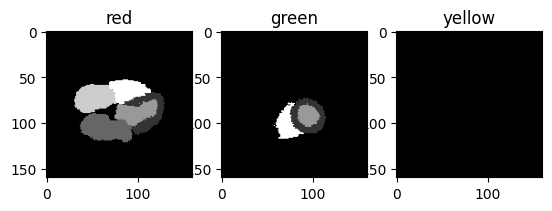

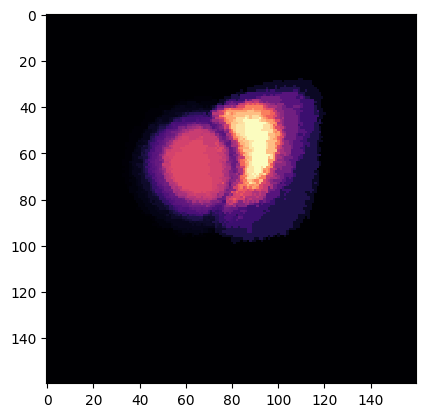

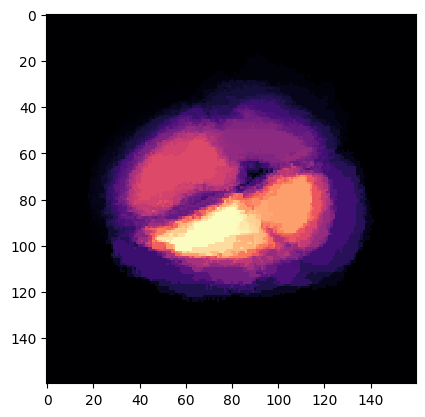

In [17]:
# DO_SAVE = True
# _4CH_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_4CH.mat"))
# _SA_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA_MID_CENTER.mat"))

# FOV_MM = torch.tensor([224,224,224])
# FOV_VOX = torch.tensor([160,160,160])

# sa_sum = []
# hla_sum = []

# with torch.no_grad():
#     for p_id in range(1001,1021):
#         for mod_id in ['mr']:
#             mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_image_registered.nii.gz")
#             mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_label_registered.nii.gz")

#             if not (mri_path.is_file() and mri_gt_path.is_file()): 
#                 mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_test_selection/{mod_id}_test_selection_{p_id}_image_registered.nii.gz")
#                 mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_test_selection/{mod_id}_test_selection_{p_id}_label_registered.nii.gz")

#             nii = nib.load(mri_path)
#             gt_nii = nib.load(mri_gt_path)

#             hla_mat = _4CH_to_ras_mat 
#             sa_mat = _SA_to_ras_mat

#             data = torch.as_tensor(nii.get_fdata()).unsqueeze(0).unsqueeze(0)
#             gt_data = torch.as_tensor(gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0)
#             affine = torch.as_tensor(nii.affine)
#             gt_affine = torch.as_tensor(gt_nii.affine)

#             gt_data = replace_label_values(gt_data)

#             hla_volume, _, hla_affine = nifti_transform(data, affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX)
#             hla_label, _, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)
#             sa_volume, _, sa_affine = nifti_transform(data, affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX)
#             sa_label, _, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)

#             output_sa_image_volume_path = replace_volume_paths(mri_path, 'standard_hires', 'sa')
#             output_hla_image_volume_path = replace_volume_paths(mri_path, 'standard_hires', 'hla')
#             output_sa_label_volume_path = replace_volume_paths(mri_gt_path, 'standard_hires', 'sa')
#             output_hla_label_volume_path = replace_volume_paths(mri_gt_path, 'standard_hires', 'hla')

#             output_sa_image_slice_path = replace_slice_paths(mri_path, 'standard_hires', 'sa')
#             output_hla_image_slice_path = replace_slice_paths(mri_path, 'standard_hires', 'hla')
#             output_sa_label_slice_path = replace_slice_paths(mri_gt_path, 'standard_hires', 'sa')
#             output_hla_label_slice_path = replace_slice_paths(mri_gt_path, 'standard_hires', 'hla')

#             hla_label_crop_dummy = hla_label.clone()
#             hla_label_crop_dummy[:,:,0,0,0] = 999
#             hla_label_crop_dummy[:,:,-1,-1,-1] = 999
#             hla_label_slc, hla_image_slc, hla_slice_affine = crop_around_label_center(
#                 label=hla_label_crop_dummy , vox_size=torch.tensor([-1,-1,1]), image=hla_volume, affine=hla_affine, 
#                 center_mode='minmax'
#             )
            
#             sa_label_crop_dummy = sa_label.clone()
#             sa_label_crop_dummy[:,:,0,0,0] = 999
#             sa_label_crop_dummy[:,:,-1,-1,-1] = 999
#             sa_label_slc, sa_image_slc, sa_slice_affine = crop_around_label_center(
#                 label=sa_label_crop_dummy , vox_size=torch.tensor([-1,-1,1]), image=sa_volume, affine=sa_affine, 
#                 center_mode='minmax'
#             )

#             # Squeeze all
#             hla_label_slc, hla_image_slc = hla_label_slc.flatten(0,2), hla_image_slc.flatten(0,2)
#             sa_label_slc, sa_image_slc = sa_label_slc.flatten(0,2), sa_image_slc.flatten(0,2)

#             hla_affine, hla_slice_affine = hla_affine.flatten(0,1), hla_slice_affine.flatten(0,1)
#             sa_affine, sa_slice_affine = sa_affine.flatten(0,1), sa_slice_affine.flatten(0,1)

#             hla_label, hla_volume = hla_label.flatten(0,2), hla_volume.flatten(0,2)
#             sa_label, sa_volume = sa_label.flatten(0,2), sa_volume.flatten(0,2)

#             if DO_SAVE:
#                 output_hla_image_volume_path.parent.mkdir(exist_ok=True, parents=True)
#                 # Save image volumes
#                 nib.save(nib.Nifti1Image(hla_volume.numpy(), affine=hla_affine.numpy()), output_hla_image_volume_path)
#                 nib.save(nib.Nifti1Image(sa_volume.numpy(), affine=sa_affine.numpy()), output_sa_image_volume_path)
#                 # Save label volumes
#                 nib.save(nib.Nifti1Image(hla_label.numpy(), affine=hla_affine.numpy()), output_hla_label_volume_path)
#                 nib.save(nib.Nifti1Image(sa_label.numpy(), affine=sa_affine.numpy()), output_sa_label_volume_path)

#                 output_hla_image_slice_path.parent.mkdir(exist_ok=True, parents=True)
#                 # Save image slices
#                 nib.save(nib.Nifti1Image(hla_image_slc.numpy(), affine=hla_affine.numpy()), output_hla_image_slice_path)
#                 nib.save(nib.Nifti1Image(sa_image_slc.numpy(), affine=sa_affine.numpy()), output_sa_image_slice_path)
#                 # Save label slices
#                 nib.save(nib.Nifti1Image(hla_label_slc.int().numpy(), affine=hla_affine.numpy()), output_hla_label_slice_path)
#                 nib.save(nib.Nifti1Image(sa_label_slc.int().numpy(), affine=sa_affine.numpy()), output_sa_label_slice_path)

#             if p_id == 1002:
#                 plot_slices(hla_label_slc.squeeze(), sa_label_slc.squeeze(), torch.zeros_like(sa_label_slc.squeeze()), vmax=hla_label_slc.max().item())
            
#             if 'train' in str(output_hla_image_volume_path):
#                 sa_sum.append(sa_label_slc.squeeze())
#                 hla_sum.append(hla_label_slc.squeeze())

# plt.imshow(torch.stack(sa_sum, dim=0).sum(0).numpy().T, cmap='magma', interpolation='none')
# plt.show()

# plt.imshow(torch.stack(hla_sum, dim=0).sum(0).numpy().T, cmap='magma', interpolation='none')
# plt.show()

# Retrieve hires augmented slices from standard  (integrated above)

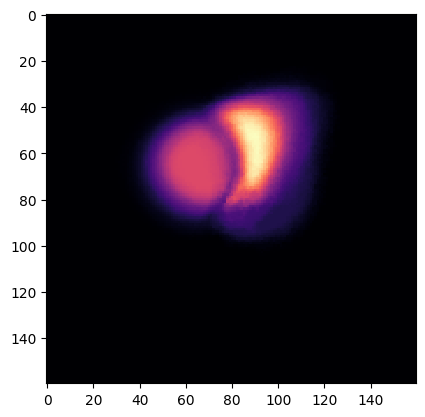

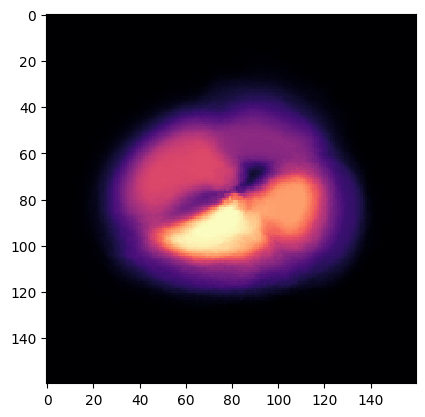

In [20]:
# DO_SAVE = True

# _4CH_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_4CH.mat"))
# _SA_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA_MID_CENTER.mat"))

# FOV_MM = torch.tensor([224,224,224])
# FOV_VOX = torch.tensor([160,160,160])

# sa_sum = []
# hla_sum = []

# with torch.no_grad():
#     for p_id in range(1001,1021):
#         for mod_id in ['mr']:
#             mri_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_image_registered.nii.gz")
#             mri_gt_path = Path(MMWHS_BASE_PATH, f"{mod_id}_registered_train_selection/{mod_id}_train_selection_{p_id}_label_registered.nii.gz")

#             if not (mri_path.is_file() and mri_gt_path.is_file()): 
#                 # Do not augment test data
#                 continue
            
#             nii = nib.load(mri_path)
#             gt_nii = nib.load(mri_gt_path)

#             hla_mat = _4CH_to_ras_mat 
#             sa_mat = _SA_to_ras_mat

#             data = torch.as_tensor(nii.get_fdata()).unsqueeze(0).unsqueeze(0)
#             gt_data = torch.as_tensor(gt_nii.get_fdata()).unsqueeze(0).unsqueeze(0)
#             affine = torch.as_tensor(nii.affine)
#             gt_affine = torch.as_tensor(gt_nii.affine)

#             gt_data = replace_label_values(gt_data)

#             for aug_idx in range(20):
#                 aug_affine = get_random_affine(rotation_strength=0.3)

#                 hla_volume, _, hla_affine = nifti_transform(data, affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, pre_grid_sample_affine=aug_affine)
#                 hla_label, _, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), hla_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True, pre_grid_sample_affine=aug_affine)
#                 sa_volume, _, sa_affine = nifti_transform(data, affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, pre_grid_sample_affine=aug_affine)
#                 sa_label, _, _ = nifti_transform(gt_data, gt_affine.unsqueeze(0), sa_mat.unsqueeze(0), fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True, pre_grid_sample_affine=aug_affine)

#                 output_sa_image_slice_path = replace_slice_paths(mri_path, 'standard_hires', idx=aug_idx, ornt='sa')
#                 output_hla_image_slice_path = replace_slice_paths(mri_path, 'standard_hires', idx=aug_idx, ornt='hla')
#                 output_sa_label_slice_path = replace_slice_paths(mri_gt_path, 'standard_hires', idx=aug_idx, ornt='sa')
#                 output_hla_label_slice_path = replace_slice_paths(mri_gt_path, 'standard_hires', idx=aug_idx, ornt='hla')

#                 hla_label_crop_dummy = hla_label.clone()
#                 hla_label_crop_dummy[:,:,0,0,0] = 999
#                 hla_label_crop_dummy[:,:,-1,-1,-1] = 999
#                 hla_label_slc, hla_image_slc, hla_slice_affine = crop_around_label_center(
#                     label=hla_label_crop_dummy , vox_size=torch.tensor([-1,-1,1]), image=hla_volume, affine=hla_affine, 
#                     center_mode='minmax'
#                 )
                
#                 sa_label_crop_dummy = sa_label.clone()
#                 sa_label_crop_dummy[:,:,0,0,0] = 999
#                 sa_label_crop_dummy[:,:,-1,-1,-1] = 999
#                 sa_label_slc, sa_image_slc, sa_slice_affine = crop_around_label_center(
#                     label=sa_label_crop_dummy , vox_size=torch.tensor([-1,-1,1]), image=sa_volume, affine=sa_affine, 
#                     center_mode='minmax'
#                 )

#                 # Squeeze all
#                 hla_label, hla_volume = hla_label.flatten(0,2), hla_volume.flatten(0,2)
#                 sa_label, sa_volume = sa_label.flatten(0,2), sa_volume.flatten(0,2)

#                 hla_label_slc, hla_image_slc = hla_label_slc.flatten(0,2), hla_image_slc.flatten(0,2)
#                 sa_label_slc, sa_image_slc = sa_label_slc.flatten(0,2), sa_image_slc.flatten(0,2)

#                 hla_affine, hla_slice_affine = hla_affine.flatten(0,1), hla_slice_affine.flatten(0,1)
#                 sa_affine, sa_slice_affine = sa_affine.flatten(0,1), sa_slice_affine.flatten(0,1)

#                 if DO_SAVE:
#                     output_hla_image_slice_path.parent.mkdir(exist_ok=True, parents=True)
#                     # Save image slices
#                     nib.save(nib.Nifti1Image(hla_image_slc.numpy(), affine=hla_affine.numpy()), output_hla_image_slice_path)
#                     nib.save(nib.Nifti1Image(sa_image_slc.numpy(), affine=sa_affine.numpy()), output_sa_image_slice_path)
#                     # Save label slices
#                     nib.save(nib.Nifti1Image(hla_label_slc.int().numpy(), affine=hla_affine.numpy()), output_hla_label_slice_path)
#                     nib.save(nib.Nifti1Image(sa_label_slc.int().numpy(), affine=sa_affine.numpy()), output_sa_label_slice_path)
            
#                     # output_hla_image_volume_path.parent.mkdir(exist_ok=True, parents=True)
#                     # Save image volumes
#                     # nib.save(nib.Nifti1Image(hla_volume.numpy(), affine=hla_affine.numpy()), output_hla_image_volume_path)
#                     # nib.save(nib.Nifti1Image(sa_volume.numpy(), affine=sa_affine.numpy()), output_sa_image_volume_path)
#                     # Save label volumes
#                     # nib.save(nib.Nifti1Image(hla_label.numpy(), affine=hla_affine.numpy()), output_hla_label_volume_path)
#                     # nib.save(nib.Nifti1Image(sa_label.numpy(), affine=sa_affine.numpy()), output_sa_label_volume_path)
                    
#                 if 'train' in str(output_hla_image_slice_path):
#                     sa_sum.append(sa_label_slc.squeeze())
#                     hla_sum.append(hla_label_slc.squeeze())

#             if p_id == 1002:
#                 plot_slices(hla_label_slc.squeeze(), sa_label_slc.squeeze(), torch.zeros_like(sa_label_slc.squeeze()), vmax=hla_label_slc.max().item())

# plt.imshow(torch.stack(sa_sum, dim=0).sum(0).numpy().T, cmap='magma', interpolation='none')
# plt.show()

# plt.imshow(torch.stack(hla_sum, dim=0).sum(0).numpy().T, cmap='magma', interpolation='none')
# plt.show()